# $\hspace{1cm}$ PRÁCTICA FINAL APRENDIZAJE AUTOMÁTICO

# $\hspace{3.5cm}$ DETECCIÓN DE SINIESTROS

Marta Simón Arévalo y Pablo Zornoza Ligero

### 1. LIBRERÍAS

Antes de comenzar la práctica importaremos los paquetes y las librerías que necesitaremos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

### 2. INTRODUCCIÓN 

En el siguiente proyecto abordaremos un problema de clasificación relacionado con la detección de siniestros. 

El conjunto de datos contiene los datos de colisión de los accidentes automovilísticos ocurridos en Canadá de 1999-2014 según lo proporcionado por Transport Canada. Este conjunto de datos proporciona varias características como la hora del día, si hubo o no muertes, género del conductor, etc.


Con el análisis podremos contestar a preguntas tales como:
- ¿Qué tipos de vehículos y conductores son más propensos a tener accidentes?
 
- ¿Qué tipos de vehículos y conductores son menos propensos a tener accidentes?

-  ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?


Nos plantearemos dos problemas de clasificación diferentes:
1. Identificar los accidentes en los que puedan producirse víctimas.

2. Diferenciar los accidentes que ocasionarán heridos de los que no. 


### 3. VARIABLES

Las variables que forman el conjunto de datos son los siguientes: 

1. Variables relacionadas con los accidentes:
  - **C_YEAR**: año del accidente.
  - **C_MNTH**: mes del accidente.
  - **C_WDAY**: día de la semana en el cuál ocurrió el accidente.
  - **C_HOUR**: hora en la que se produce el accidente.
  - **C_SEV**: gravedad de la colisión.
  - **C_VEHS**: número de vehículos involucrados en el accidente.
  - **C_CONF**: configuración de la colisión.
  - **C_RCFG**: configuración de la carretera.
  - **C_WTHR**: condición climatológica.
  - **C_RSUR**: estado de la superficie de la carretera.
  - **C_RALN**: alineación vial.
  - **C_TRAF**: control de tráfico.
  
  
2. Variables relacionadas con el vehículo:
  - **V_ID**: número de secuencia del vehículo.
  - **V_TYPE**: tipo de vehículo.
  - **V_YEAR**: año del modelo de vehículo.
  
  
3. Variables relacionadas con los pasajeros.
  - **P_ID**: número de secuencia del pasajero.
  - **P_SEX**: género del pasajero.
  - **P_AGE**: edad del pasajero.
  - **P_PSN**: posición del pasajero en el vehículo.
  - **P_ISEV**: requerimiento de tratamiento médico.
  - **P_SAFE**: dispositivo de seguridad utilizado.
  - **P_USER**: clase de usuario de la carretera.
  
Estos datos han sido tomados del documento drivingLegend.pdf

In [2]:
df = pd.read_csv('NCDB_1999_to_2014.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


Eliminamos las variables identificadoras `V_ID` y `P_ID`, ya que no serán de utilidad para nuestro problema. 

In [3]:
df = df.drop(['V_ID','P_ID'], axis=1)

Veámos si existen valores duplicados en el dataset y los eliminamos también:

In [4]:
print('Número de valores duplicados:', df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()

Número de valores duplicados: 36332


### 4. PREPROCESSING Y VISUALIZACIÓN

#### Tratamiento de los valores missing

Para poder realizar el tratamiento de los valores nulos, tenemos que analizar los valores que toman alguna de las variables y convertirlos en valores missing.

Hay variables que toman valores del tipo *'U','UU','UUUUU'* cuando el valor real es desconocido, y *'X','XX','XXXX'* cuando la jurisdicción no aporta dicho valor. Así pues, denominaremos a dichos valores como **valores missing**.
 
También tenemos otras variables que toman valores del tipo *'Q','QQ'* (la elección es distinta de los valores anteriores), al igual que hemos hecho con los valores anteriores los denomiraremos como **valores missing**.

In [5]:
df = df.replace({'U' : np.nan, 'UU' : np.nan, 'UUUU' : np.nan})

In [6]:
df = df.replace({'X' : np.nan, 'XX' : np.nan, 'XXXX' : np.nan})

In [7]:
df = df.replace({'Q' : np.nan, 'QQ' : np.nan})

Por último, existen valores que empiezan por 'N', estos datos son elementos de datos no aplicables (p.ej., registro de vehículo "ficticio" creado para el peatón o registro de persona "ficticia" creado para automóviles que se encuentran estacionados).

Puesto que nuestro objetivo es predecir los posibles casos de personas heridas o fallecidas en un accidente, vamos a eliminar estas los datos que hacen referencia a los coches estacionados ya que no nos aportan la información que necesitamos, pero mantendremos los datos que hacen referencia a los peatones involucrados en los accidentes. 

In [8]:
df = df.loc[(df['P_SEX']!='N') & (df['P_AGE']!='NN') & (df['P_PSN']!='NN') & (df['P_ISEV']!='N') & (df['P_SAFE']!='NN')]

Ahora ya podemos estudiar los valores nulos, primero veremos la cantidad de valores nulos que tenemos por columnas:

In [9]:
null_c = df.isnull().sum().sort_values(ascending=False)
df_null_c = pd.DataFrame(null_c, columns=['Nulos(Columnas)'])   
df_null_c['Porcentaje(Columnas)'] = df_null_c['Nulos(Columnas)']/df.shape[0]
df_null_c.head()

,Nulos(Columnas),Porcentaje(Columnas)
P_SAFE,612269,0.117258
C_RCFG,567365,0.108658
C_RALN,441667,0.084585
C_CONF,386439,0.074008
C_TRAF,259524,0.049702


Nuestro dataset contienen un bajo porcentaje de missing por columnas, estando todas ellas por debajo del 20%. 

Estudiemos pues, la cantidad de valores nulos que tenemos por filas, con la intención de ver si hay alguna fila que podamos eliminar

In [10]:
null_r = df.isnull().sum(axis=1).sort_values(ascending=False)
df_null_r = pd.DataFrame(null_r, columns=['Nulos(Filas)'])  
df_null_r['Porcentaje(Filas)']= df_null_r['Nulos(Filas)']/df.shape[1]
df_null_r.head()

,Nulos(Filas),Porcentaje(Filas)
5245711,16,0.80
1244965,14,0.70
2979011,13,0.65
526260,13,0.65
2509005,13,0.65


En este caso, las filas tienen un porcentaje de missing superior al 50%, por lo tanto podemos plantearnos eliminarlas de nuestra base de datos.

La cantidad de filas que hay conteniendo un número determinado de valores nulos son:

In [11]:
df_null_r['Nulos(Filas)'].value_counts()

0     3363242
1      972214
2      484238
3      217434
4       77383
5       49108
6       37659
7       11641
8        4881
9        2237
10        964
11        338
12        192
13         40
16          1
14          1
Name: Nulos(Filas), dtype: int64

A continuación procederemos con el tratamiento de los valores missing.

Observamos que todas las variables son discretas de tipo categórico, por lo que no es correcto sustituir los valores nulos por la media o por la mediana.

Podríamos plantearnos crar una nueva variable la cual nos idique que son valores nulos, pero debido al elevado número de observaciones que tenemos es más adecuado eliminar las observaciones con valores nulos.

In [12]:
df = df.dropna()

Comprobemos que no quedan valores missing:

In [13]:
null = df.isnull().sum(axis=1).sort_values(ascending=False)
df_null = pd.DataFrame(null, columns=['Valores nulos']) 
df_null.head()

,Valores nulos
5860380,0
1962507,0
1962526,0
1962525,0
1962516,0


In [14]:
print('Valores nulos:', df.isnull().sum().sum())

Valores nulos: 0


#### Tipos de Variables

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363242 entries, 52 to 5860380
Data columns (total 20 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   C_YEAR  int64 
 1   C_MNTH  object
 2   C_WDAY  object
 3   C_HOUR  object
 4   C_SEV   int64 
 5   C_VEHS  object
 6   C_CONF  object
 7   C_RCFG  object
 8   C_WTHR  object
 9   C_RSUR  object
 10  C_RALN  object
 11  C_TRAF  object
 12  V_TYPE  object
 13  V_YEAR  object
 14  P_SEX   object
 15  P_AGE   object
 16  P_PSN   object
 17  P_ISEV  object
 18  P_SAFE  object
 19  P_USER  object
dtypes: int64(2), object(18)
memory usage: 538.8+ MB


Vemos que el dataset contiene 2 columnas de tipo **int64**, y 18 de tipo **object**.

Nuestro dataset está constituído principalmente por variables categóricas, excepcto las variables `P_AGE`, `V_YEAR` y `C_VEHS`, que son discretas. Así que convertiremos estas variables en int64.

Cabe destacar que al trabajar con el dataset hemos notado que existen valores en ciertas variables que no han sido imputados correctamente, como por ejemplo en la variable `C_WDAY`:

In [16]:
df['C_WDAY'].value_counts()

5    295698
5    278150
6    265871
4    249518
4    245361
1    240142
6    238597
3    237621
2    235174
2    231651
3    230919
7    226640
1    203042
7    184858
Name: C_WDAY, dtype: int64

Podemos ver que todos los valores han sido contabilizados dos veces como si fuesen categorías distintas, cuando en realidad son las mismas. Este mismo problema lo tienen otras variables. Para solucionarlo, vamos a convertir todas las variables en **int64**.

Hay algunas variables que para poder convertirlas necesitamos realizar previamente algunos cambios:

Puesto que la variable `P_SEX` se trata de una variable nominal que toma los valores 'M' (Male) y 'F '(Female), tendremos que sustituir estos valores por 0 y 1, respectivamente.

Asimismo, hay valores de la forma 'NN' y 'NNN' los cuales sustituiremos por -1.

In [17]:
df['P_SEX'] = df['P_SEX'].replace({'F' : 0, 'M' : 1})
df = df.replace({'NN' : -1, 'NNNN' : -1})
df = df.astype('int64')

#### Estudio de las variables objetivo

Para poder realizar el estudio de las variables objetivo convertiremos las variables necesarias en categóricas:

In [18]:
catcolumns = df.columns.drop(['P_AGE', 'V_YEAR', 'C_VEHS'])
df[catcolumns] = df[catcolumns].astype('category')
df.dtypes

C_YEAR    category
C_MNTH    category
C_WDAY    category
C_HOUR    category
C_SEV     category
C_VEHS       int64
C_CONF    category
C_RCFG    category
C_WTHR    category
C_RSUR    category
C_RALN    category
C_TRAF    category
V_TYPE    category
V_YEAR       int64
P_SEX     category
P_AGE        int64
P_PSN     category
P_ISEV    category
P_SAFE    category
P_USER    category
dtype: object

Comenzaremos estudiando la variable objetivo `C_SEV`, la cual escogemos para tratar el problema de la la identificación de los accidentes en los que puedan producirse víctimas.

La variable *C_SEV* representa la gravedad de la colisión. Como hemos eliminado las observaciones con valores 'U' y 'X', la variable solo tendrá los siguientes valore: 
- **1**: La colisión produjo al menos un fallecido.
- **2**: La colisión solo produjo lesiones no mortales.

In [19]:
df['C_SEV'].value_counts()

2    3307607
1      55635
Name: C_SEV, dtype: int64

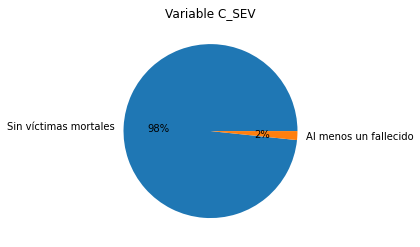

In [20]:
data = [df['C_SEV'].value_counts()[0], df['C_SEV'].value_counts()[1]]
labels = ['Sin víctimas mortales', 'Al menos un fallecido']
plt.pie(data, labels=labels, autopct='%.0f%%')
plt.title('Variable C_SEV')
plt.show()

Podemos observar que en el 98% de los accidentes que se producen no hay víctimas mortales, mientras que solo el 2% tiene al menos una víctima mortal.   

Analizaremos la relación entre las variables `C_SEV` y `C_WDAY`, es probable que los fines de semana sea más factible que la gente conduzca en estado ebrio produciendo así accidentes más graves.

In [21]:
crosstab_s_wd = pd.crosstab(index=df['C_SEV'], columns=df['C_WDAY'], margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)
crosstab_s_wd.index = ['Con victima mortal', 'Sin victimas mortales', 'Total']
crosstab_s_wd.columns = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo','Total']
crosstab_s_wd

,Lunes,Martes,Miércoles,Jueves,Viernes,Sábado,Domingo,Total
Con victima mortal,0.198588,0.195763,0.192106,0.223207,0.276341,0.299592,0.268610,1.654207
Sin victimas mortales,12.978697,13.684445,13.739095,14.491137,16.786006,14.699864,11.966549,98.345793
Total,13.177285,13.880208,13.931201,14.714344,17.062346,14.999456,12.235159,100.000000


En la tabla podemos ver que solo el 1.66% de los accidentes tuvo al menos una víctima mortal mientras que el 98.34% no tuvo víctimas mortales. 

Del 1.66% de accidentes con víctimas mortales, el **0.84%** ocurren en fin de semana (Viernes, Sábado y Domingo), un porcentaje similar al resto días (Lunes, Martes, Miércoles y Jueves) **0.82%**. 

De los datos que aparecen en los accidentes sin víctimas mortales, del 98.34% el  **43.31%** se produce los fines de semana, una cifra inferior si la comparamos con el resto de los días **55.02%**.

Así pues, no podemos asegurar que se produzcan más accidentes durante el finde semana.

Estudiaremos la relación entre las variables `C_SEV` y `C_HOUR`, ya que es posible que al oscurecer y perder visibilidad se tengan más accidenetes.

Primero dividiremos las horas por franjas horarias de la siguiente forma:
- **1** : Madrugada (0:00h - 5:59h)
- **2** : Mañana (6:00h - 11:59h)
- **3** : Medio día (12:00h - 14:59h)
- **4** : Tarde (15:00h - 19:59h)
- **5** : Noche (20:00h - 23:59h)

In [22]:
df['C_HOUR'] = df['C_HOUR'].replace(dict.fromkeys([0,1,2,3,4,5], 1))
df['C_HOUR'] = df['C_HOUR'].replace(dict.fromkeys([6,7,8,9,10,11], 2))
df['C_HOUR'] = df['C_HOUR'].replace(dict.fromkeys([12,13,14], 3))
df['C_HOUR'] = df['C_HOUR'].replace(dict.fromkeys([15,16,17,18,19], 4))
df['C_HOUR'] = df['C_HOUR'].replace(dict.fromkeys([20,21,22,23], 5))
df['C_MNTH'] = df['C_MNTH'].astype('category')

In [23]:
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
52,1999,1,1,2,2,2,34,2,1,1,1,1,1,1992,0,33,11,2,2,1
54,1999,1,1,2,2,2,34,2,1,1,1,1,1,1992,0,70,11,1,2,1
125,1999,1,1,5,2,1,3,3,1,1,3,5,1,1988,0,38,11,2,2,1
141,1999,1,1,1,2,2,1,2,3,2,4,18,6,1995,1,34,11,1,2,1
142,1999,1,1,1,2,2,1,2,3,2,4,18,6,1995,1,30,13,1,2,2


In [24]:
crosstab_sev_wthr = pd.crosstab(index=df['C_SEV'], columns=df['C_HOUR'], margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)
crosstab_sev_wthr.index = ['Con victima mortal', 'Sin victimas mortales', 'Total']
crosstab_sev_wthr.columns = ['Madrugada', 'Mañana', 'Medio dia', 'Tarde', 'Noche', 'Total']
crosstab_sev_wthr

,Madrugada,Mañana,Medio dia,Tarde,Noche,Total
Con victima mortal,0.248986,0.360307,0.265518,0.514950,0.264447,1.654207
Sin victimas mortales,6.011402,24.115660,19.287967,37.091354,11.839410,98.345793
Total,6.260388,24.475967,19.553484,37.606304,12.103857,100.000000


Como es obvio, al igual que pasaba en la tabla  anterior, podemos observar que solo el 1.65% de los accidentes tuvo al menos una víctima mortal mientras que el 98.34% no tuvo víctimas mortales. 
                  
Del 1.65% de víctimas mortales, el **0.51%** ocurren por la tarde y el **0.36%** por la mañana, unos porcentajes un poco más altos que el resto de horas. 

De los datos que aparecen en los accidentes sin víctimas mortales, del 98.34% el  **37.09%** se producen por la tarde y el **24.14%** por la mañana, unas cifras superiores si las comparamos con el resto de horas.

Esto puede deberse a que estas franjas horarias coinciden con las horas de entrada y de salida de los trabajos, son horas con una elevada circulación de vehículos.  Por lo tanto, es más fácil tener un accidente en dichas horas que en las horas en las que te encuentras trabajando o en el hogar. El problema es que no disponemos datos del número de vehículos que circulan por horas, por lo que no podemos comprobarlo.

Examinaremos la relación entre las variables `C_SEV` y `C_WTHR` ya que se puede pensar que los días con climatología más adversa puede provocar más accidentes graves y como consecuencia más víctimas mortales.

In [25]:
crosstab_sev_wthr = pd.crosstab(index=df['C_SEV'], columns=df['C_WTHR'], margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)
crosstab_sev_wthr.index = ['Con victima mortal', 'Sin victimas mortales', 'Total']
crosstab_sev_wthr.columns = ['Despejado y soleado', 'Nublado sin precipitaciones', 'LLuvioso', 'Nevado', 'LLuvia helada, aguanieve, granizo', 'Visibilidad limitada', 'Viento fuerte', 'Total']
crosstab_sev_wthr

,Despejado y soleado,Nublado sin precipitaciones,LLuvioso,Nevado,"LLuvia helada, aguanieve, granizo",Visibilidad limitada,Viento fuerte,Total
Con victima mortal,1.135690,0.18500,0.138646,0.112986,0.013796,0.059645,0.008444,1.654207
Sin victimas mortales,70.186564,9.01193,11.152781,5.857652,0.521194,1.373853,0.241820,98.345793
Total,71.322254,9.19693,11.291427,5.970638,0.534990,1.433498,0.250264,100.000000


Procediendo de la misma manera que los casos anteriores, del 1.66% de los accidentes con víctimas mortales, el **0.52%** ocurren en en los días en los que hay peor visibilidad (Nublado sin precipitacion, lLuvioso nevado, lluvia helada, aguanieve, granizo	y visibilidad limitada); un porcentaje bastante más bajo que el de los días soleados **1.14%**.

Del 98.34% de los accidentes sin victimas mortales, el **27.83%** suceden en los días con peor visibilidad, un porcentaje bastante más bajo en comparación con los que suceden los días soleados **70.19%**.
 
Es posible que esto suceda porque las personas van a una velocidad más elevada en los días con buena visibilidad, mientras que en los días con peor visibilidad suelen ser más precavidas. Al igual que nos pasaba con las horas, no disponemos de datos sobre la velocidad de los vehículos, por lo que no podemos comprobar si es por este motivo.

Ahora estudiaremos la variable objetivo `P_ISEV`, tomada para diferenciar los accidentes que ocasionarán heridos de los que no.

La variable `P_ISEV` representa el tratamiento médico requerido. Esta variable contaba inicialmente con 5 valores, pero después de eliminar los valores nulos tenemos los siguientes:
- **1**: Sin lesiones.
- **2**: Con lesiones.
- **3**: Fallecidos.

In [26]:
df['P_ISEV'].value_counts()

2    1926838
1    1413395
3      23009
Name: P_ISEV, dtype: int64

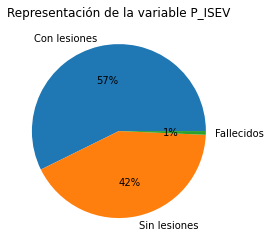

In [27]:
data = [df['P_ISEV'].value_counts()[0], df['P_ISEV'].value_counts()[1], df['P_ISEV'].value_counts()[2]]
labels = ['Con lesiones', 'Sin lesiones', 'Fallecidos']
plt.pie(data, labels=labels, autopct='%.0f%%')
plt.title('Representación de la variable P_ISEV')
plt.show()

Se observa que en el 57% de los accidentes producen lesiones, en el 42% no hay lesiones y en el 1% hay víctimas mortales.  

Ahora, vamos a estudiar si existe alguna relación entre las dos varibles objetivo, `C_SEV` y `P_ISEV`:  

In [28]:
crosstab = pd.crosstab(index=df['C_SEV'], columns=df['P_ISEV'], margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)
crosstab.index = ['Con victima mortal', 'Sin victimas mortales', 'Total']
crosstab.columns = ['Sin lesiones', 'Con lesiones', 'Fallecido', 'Total']
crosstab

,Sin lesiones,Con lesiones,Fallecido,Total
Con victima mortal,0.310623,0.659453,0.684132,1.654207
Sin victimas mortales,41.714156,56.631637,0.000000,98.345793
Total,42.024778,57.291090,0.684132,100.000000


La tabla de contingencia nos muestra que de los accidentes con víctimas mortales el **68.42%** fallece, el **65.95%** sufre alguna lesión y el **0.31%** tienen lesiones. 

En los accidentes sin victimas mortales el **41.71%** no sufre ninguna lesión y el **56.63%** tiene alguna lesión. Obviamente, al ser accidentes sin victimas mortales no hay porcentajes de fallecidos.

A continuación, representaremos los datos de la tabla de contingencia:

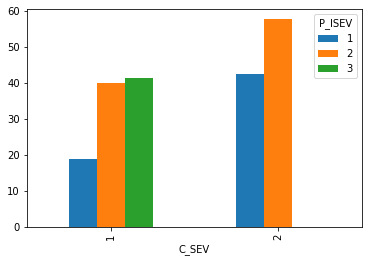

In [29]:
plot = pd.crosstab(index=df['C_SEV'],
            columns=df['P_ISEV']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')

#### Visualización de los datos

In [30]:
#Función auxiliar
import seaborn as sns

def plot_f(col_name, target):
    fig, ax = plt.subplots(1,2,figsize=(25,7))
    sns.set_theme(style="whitegrid")
    
    sns.countplot(df[col_name],ax=ax[0])
    pd.crosstab(index=df[col_name],columns=df[target]).apply(lambda r: r/r.sum(),
                                              axis=1).plot(kind='bar',ax=ax[1])

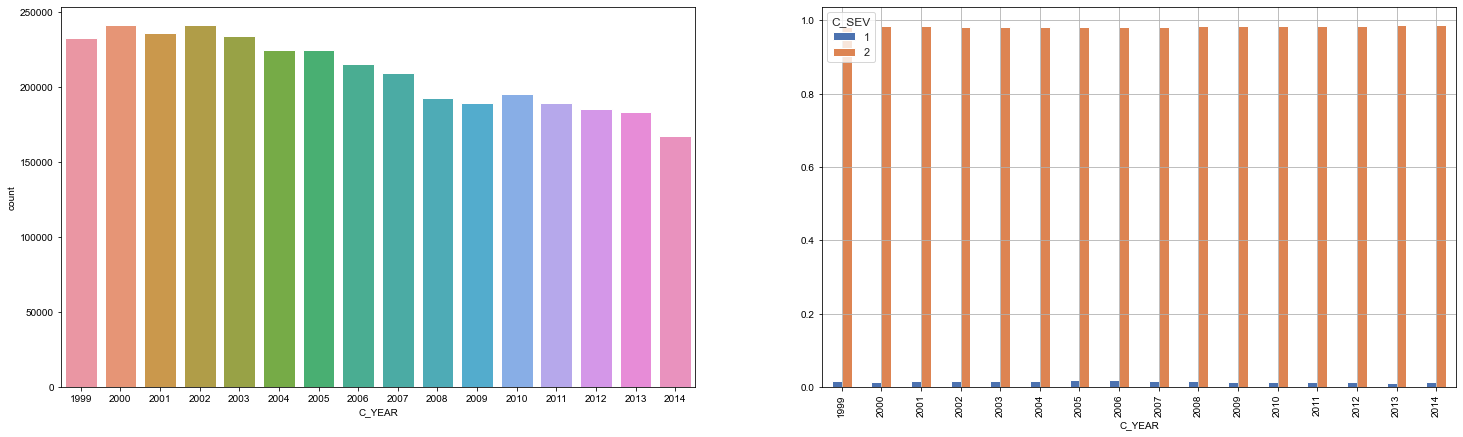

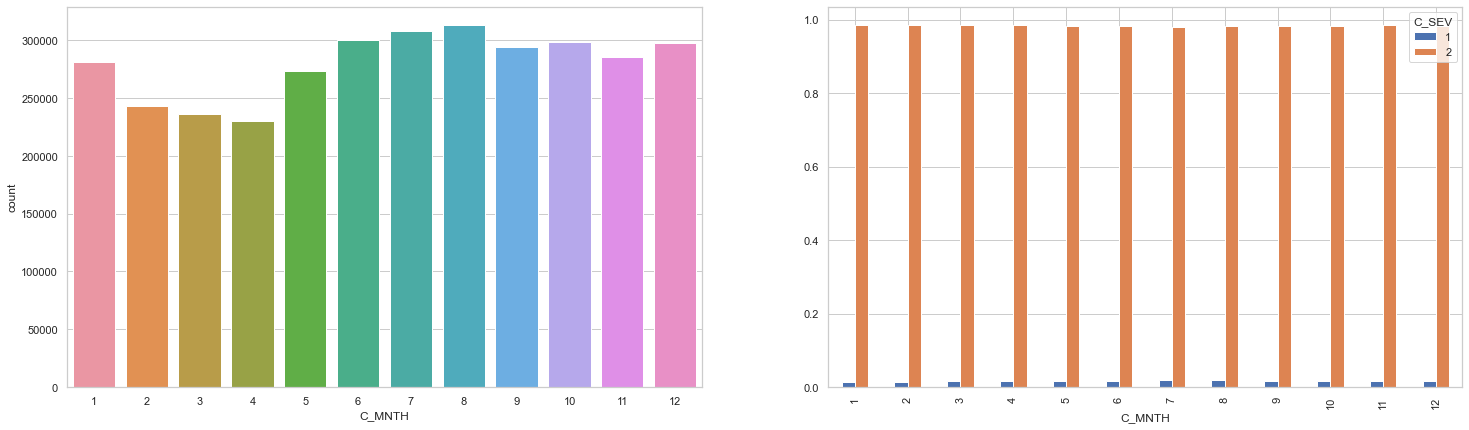

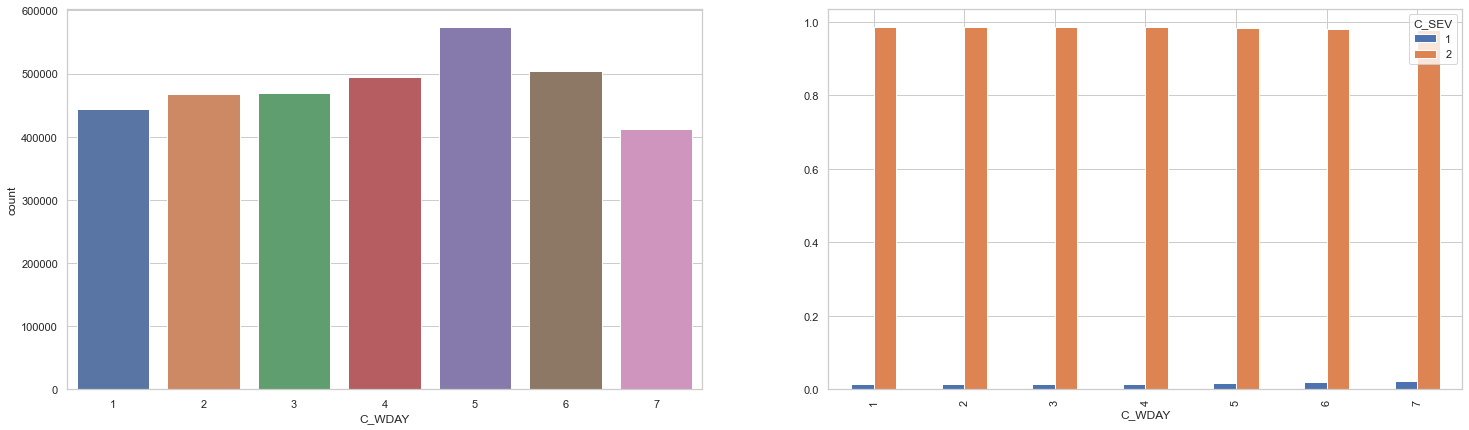

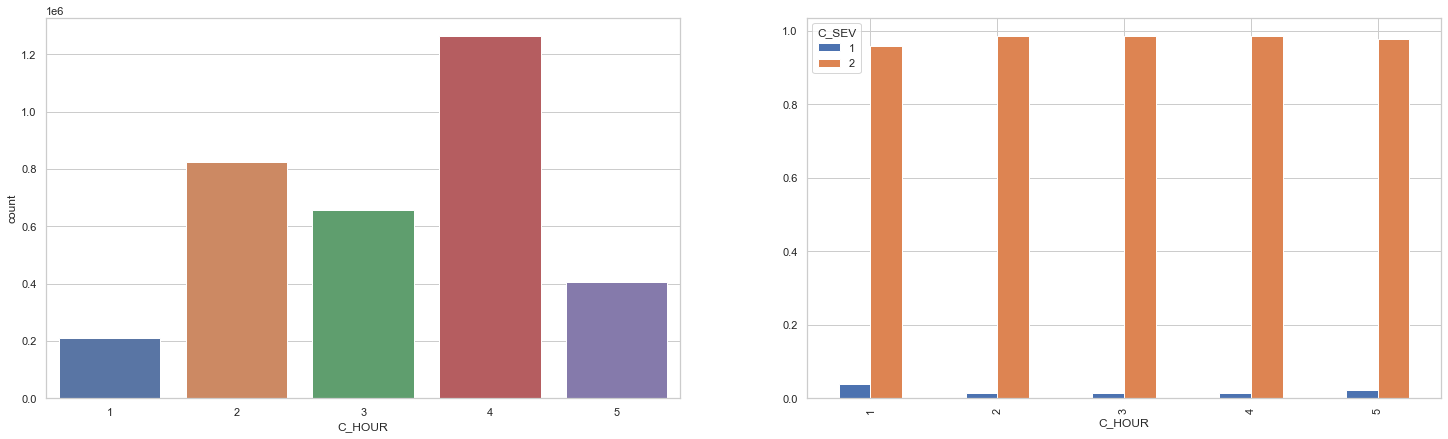

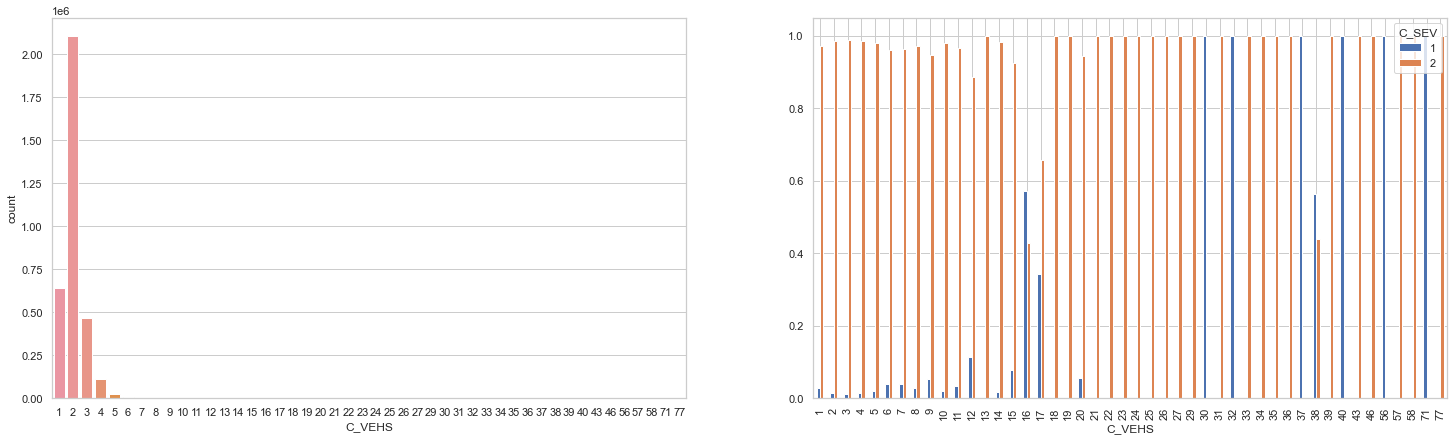

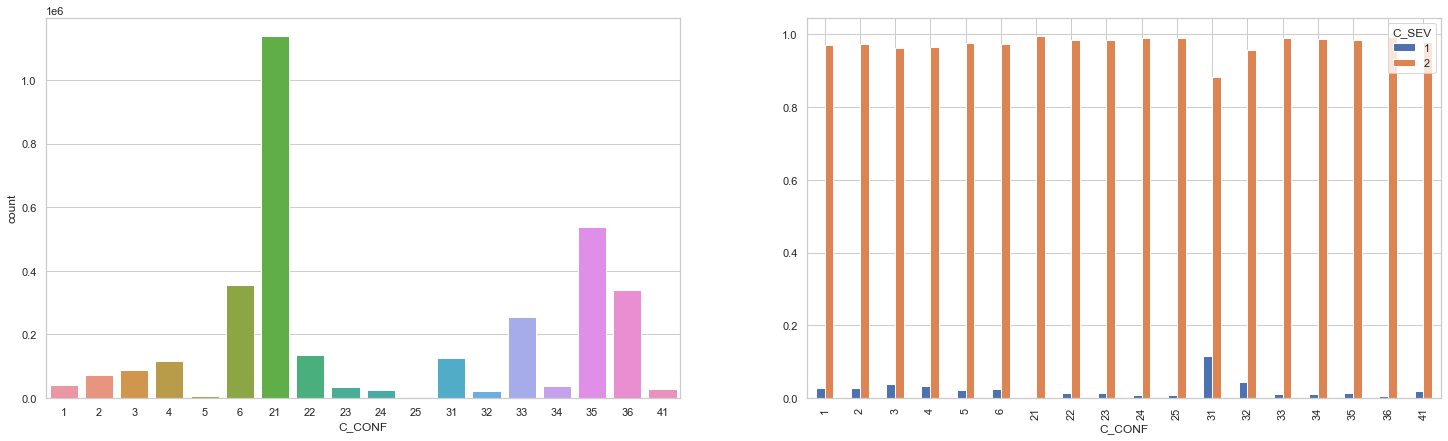

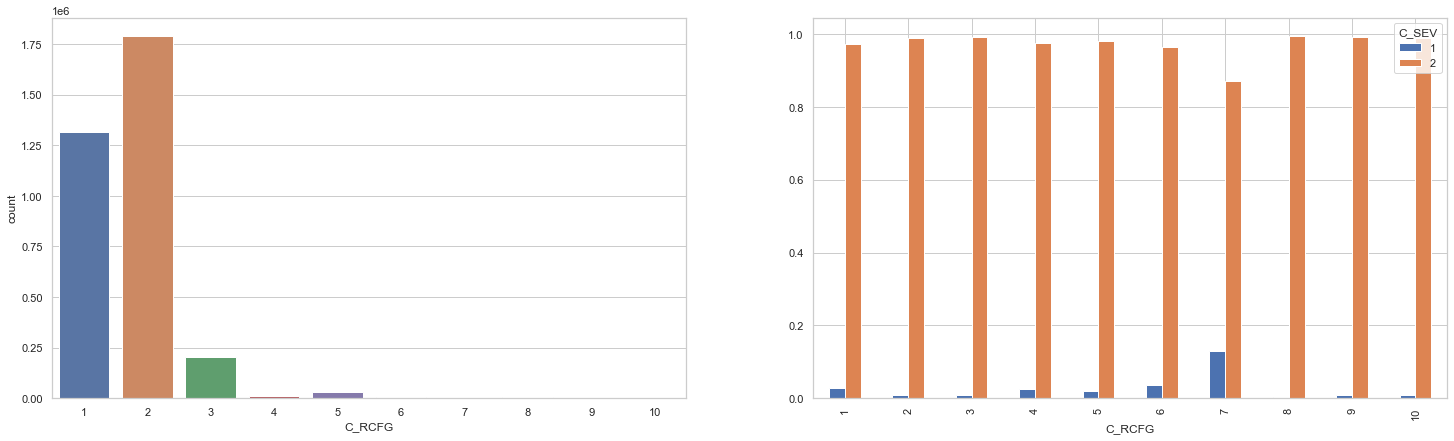

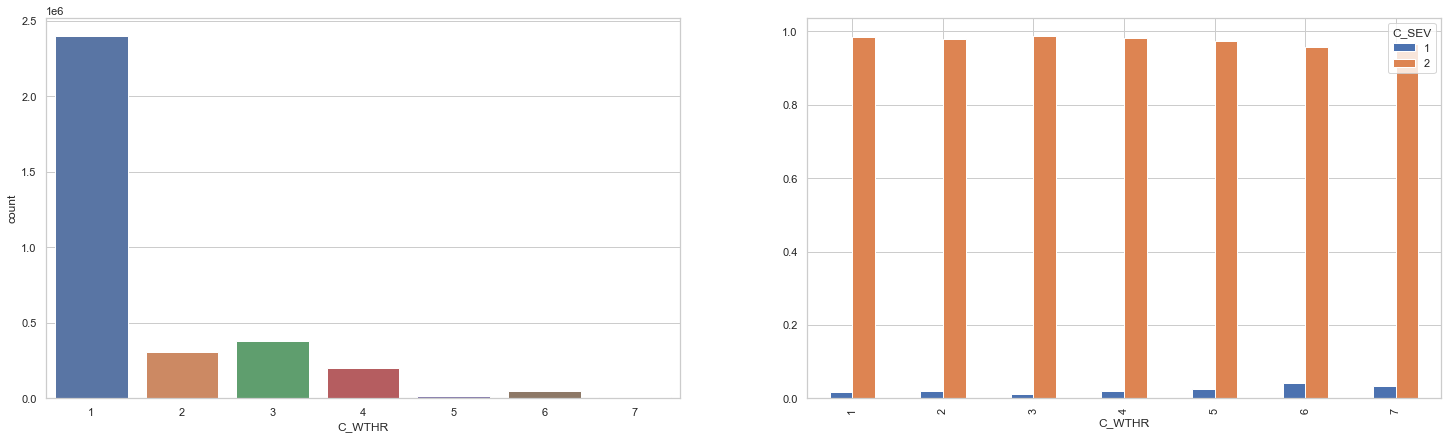

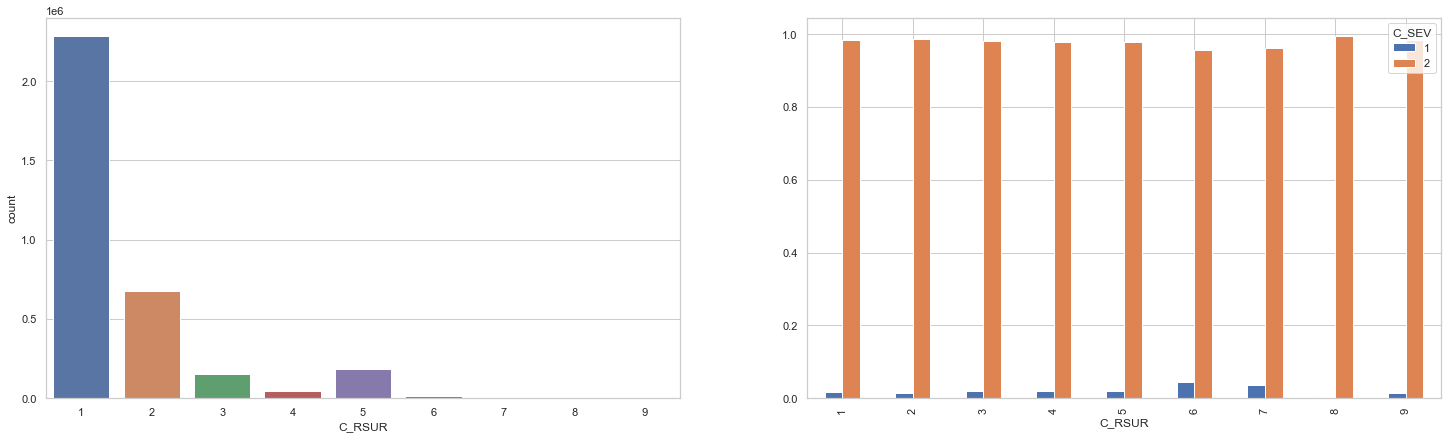

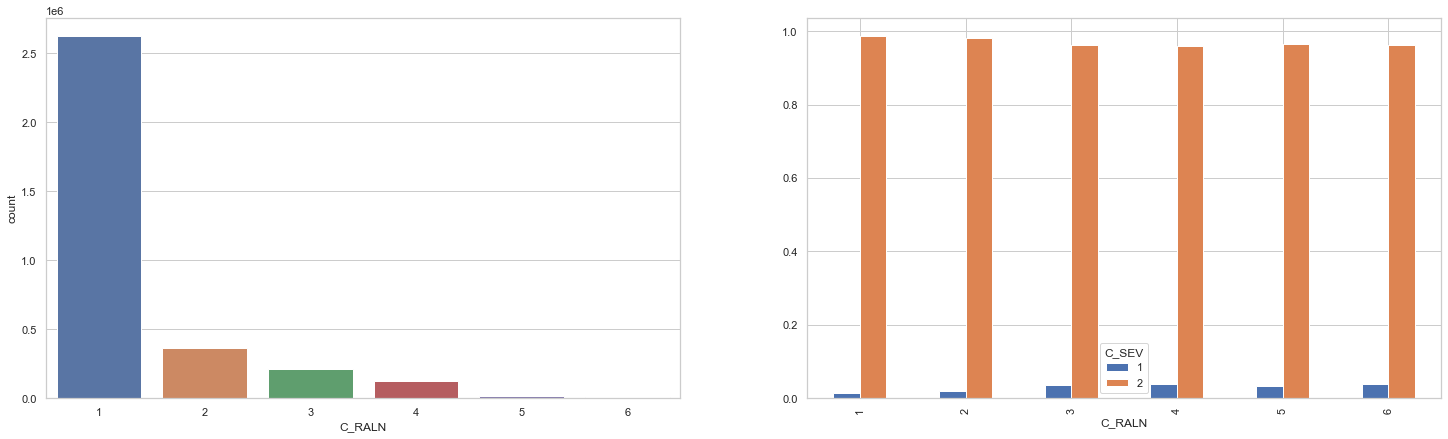

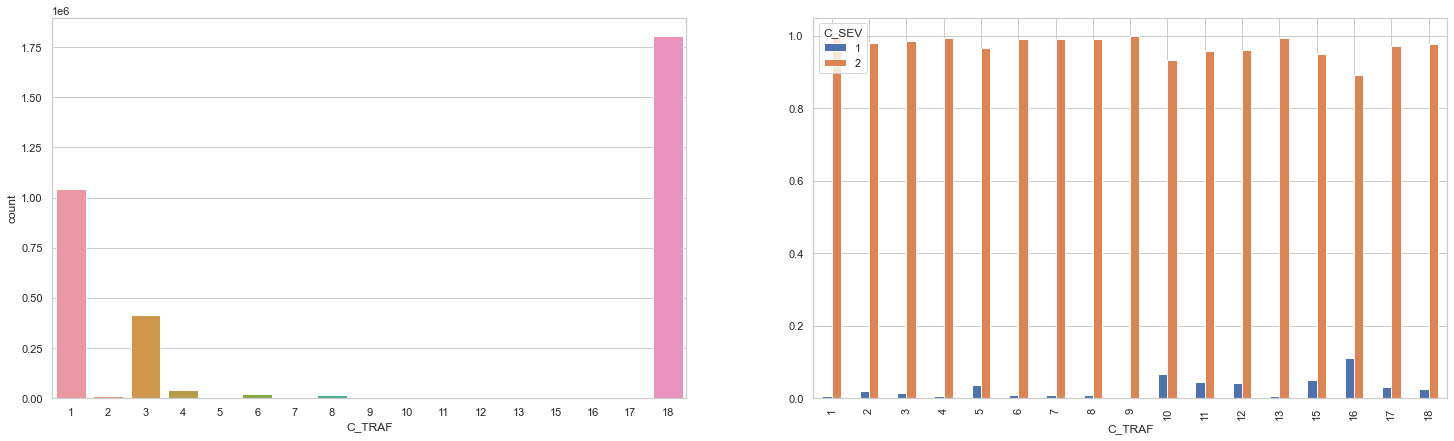

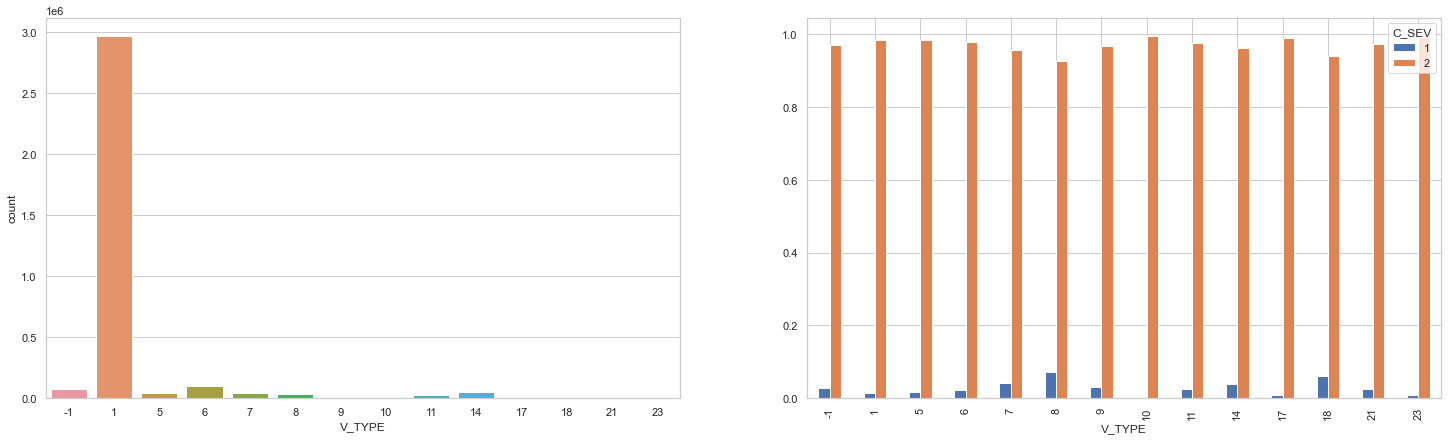

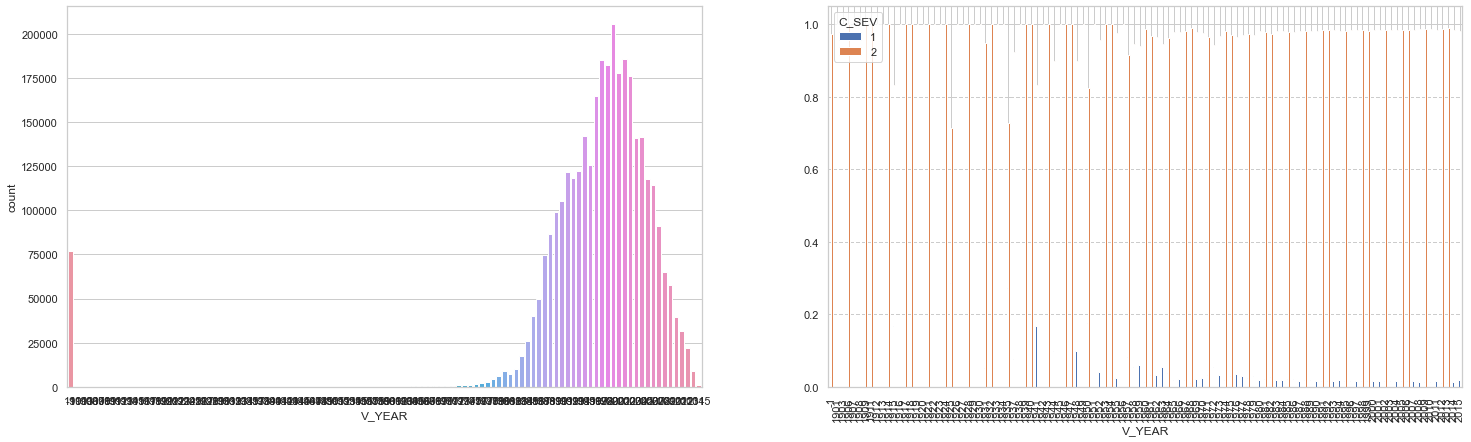

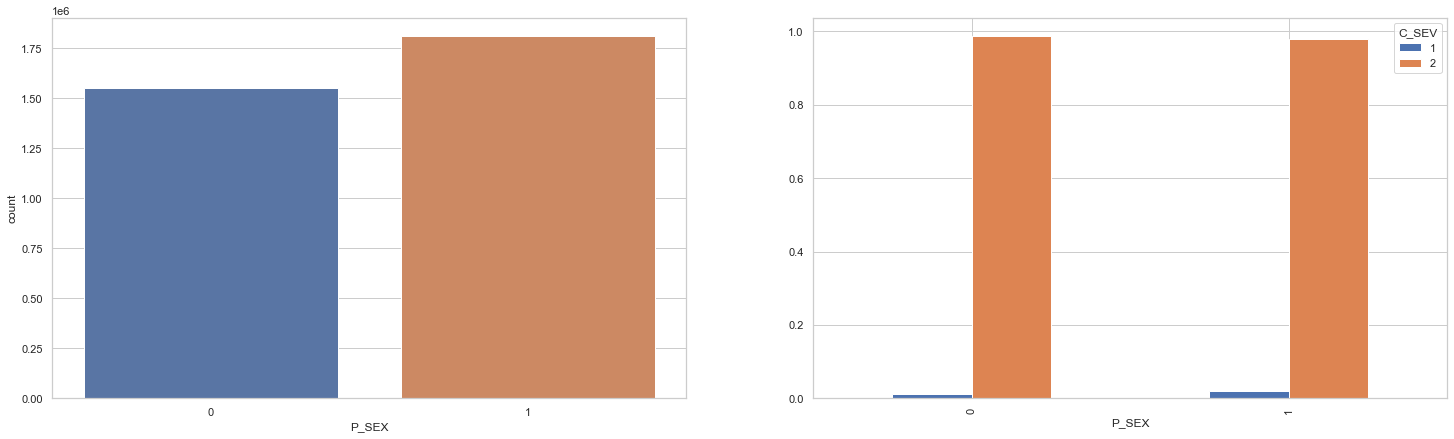

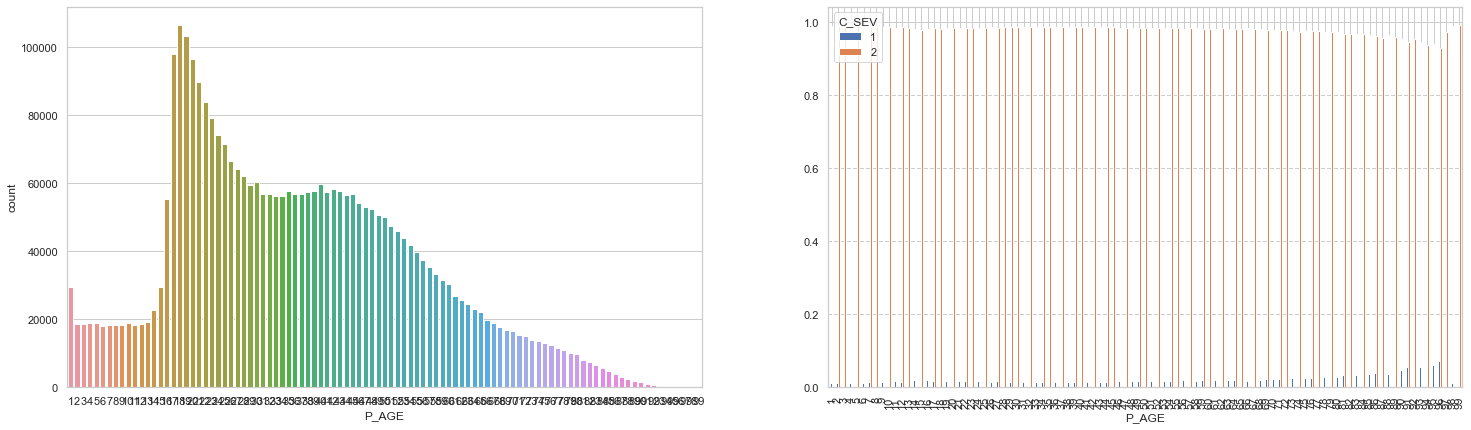

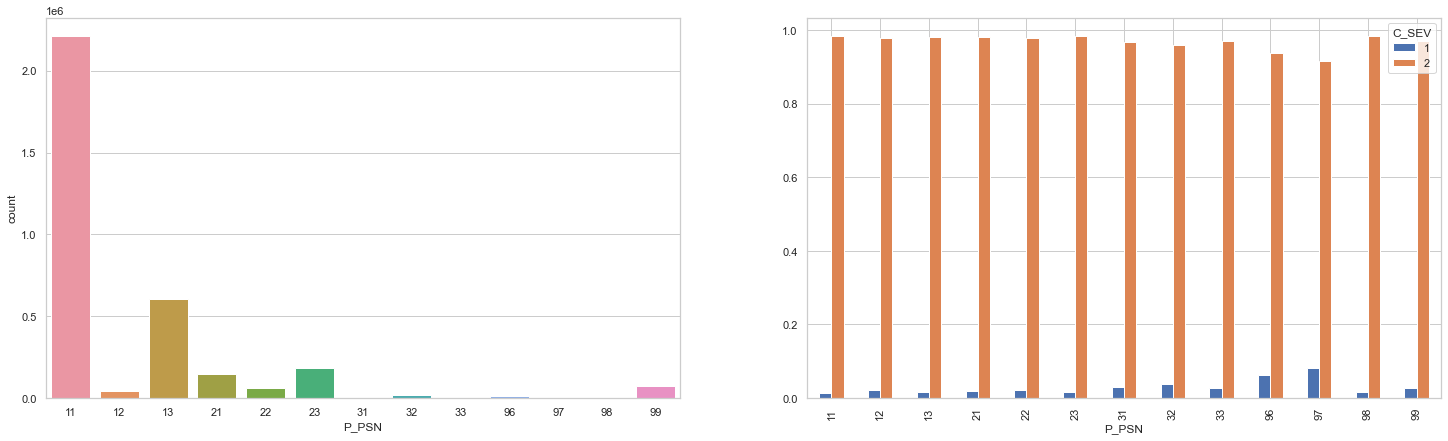

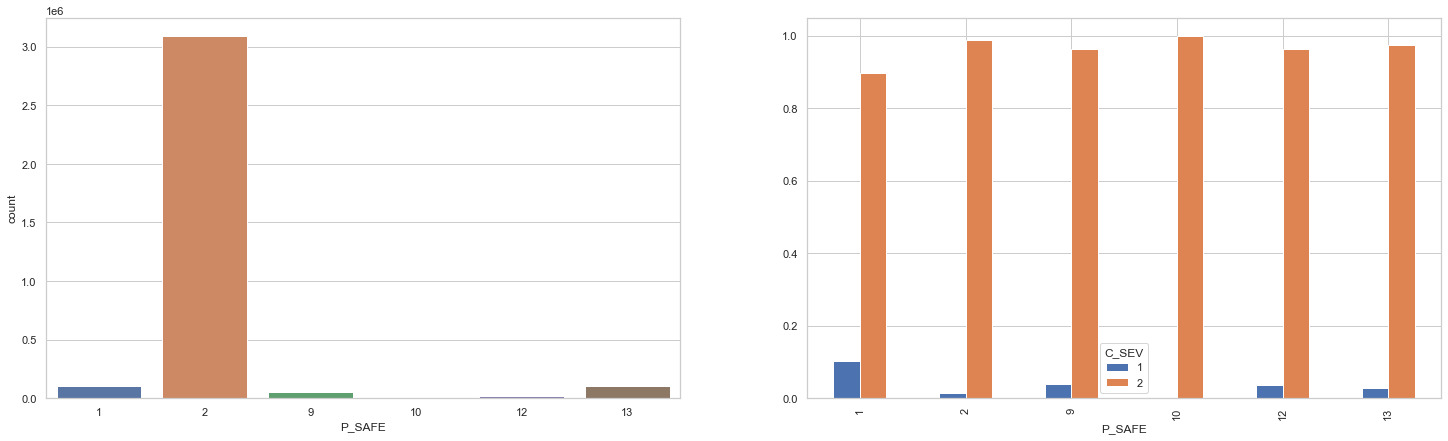

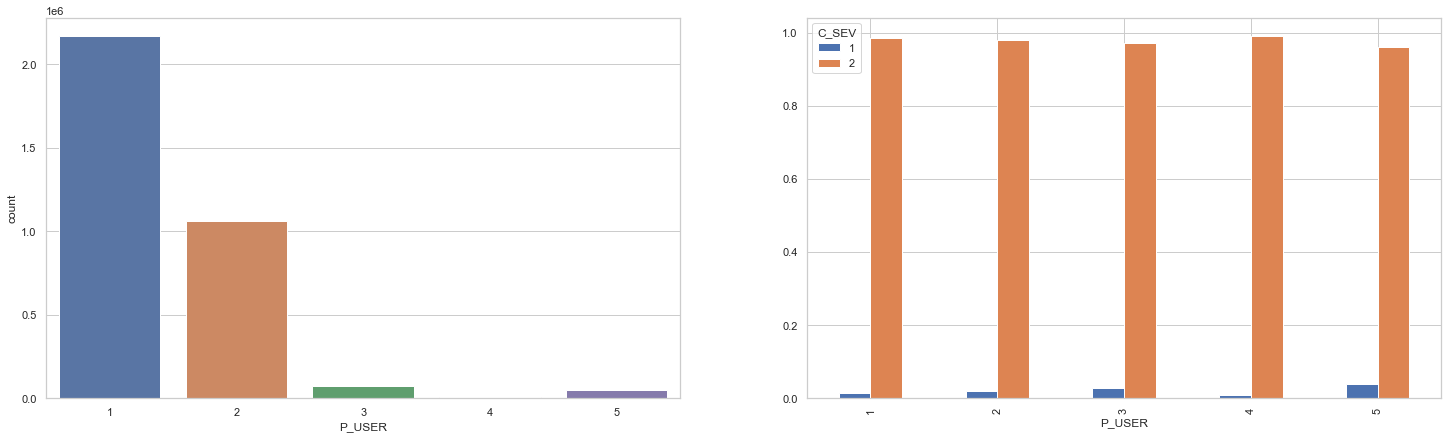

In [31]:
df_c = df.copy() 
df_csev = df_c.drop('P_ISEV', axis=1)
for i in list(df_csev):
    if  i!='C_SEV':
        plot_f(col_name = i, target ='C_SEV')

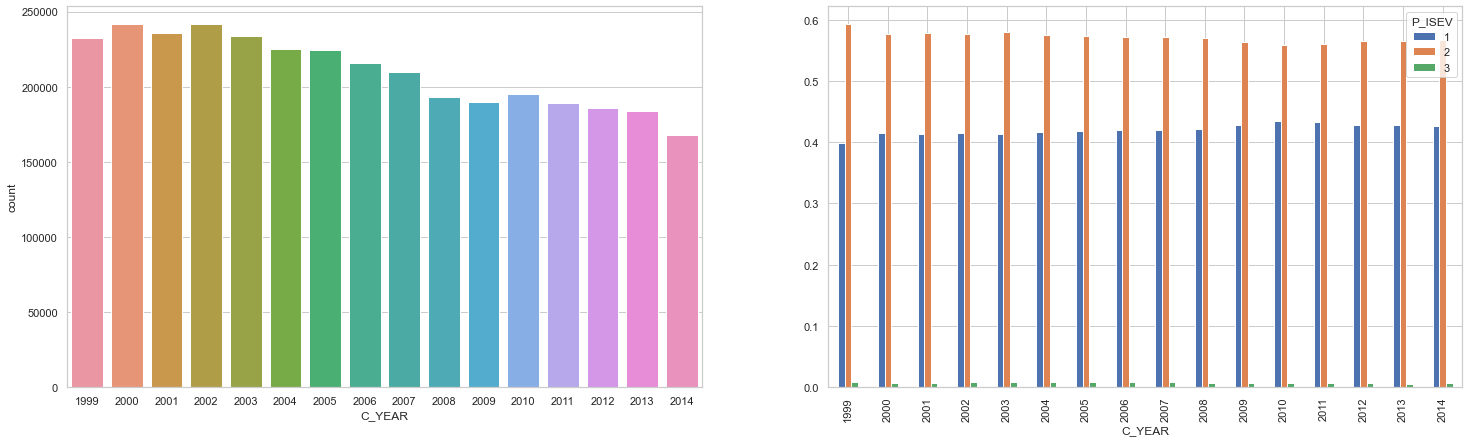

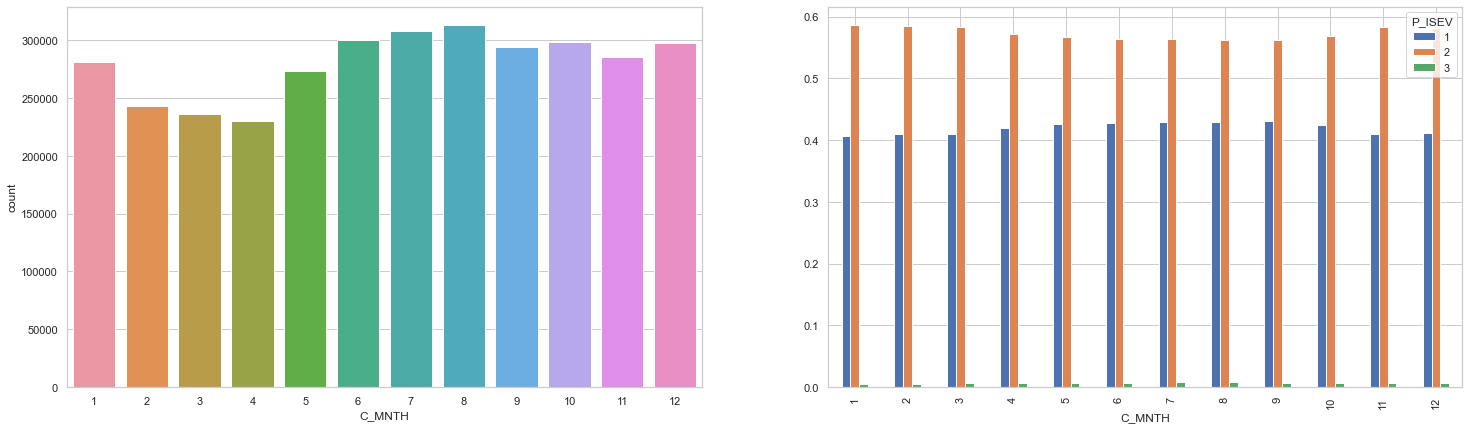

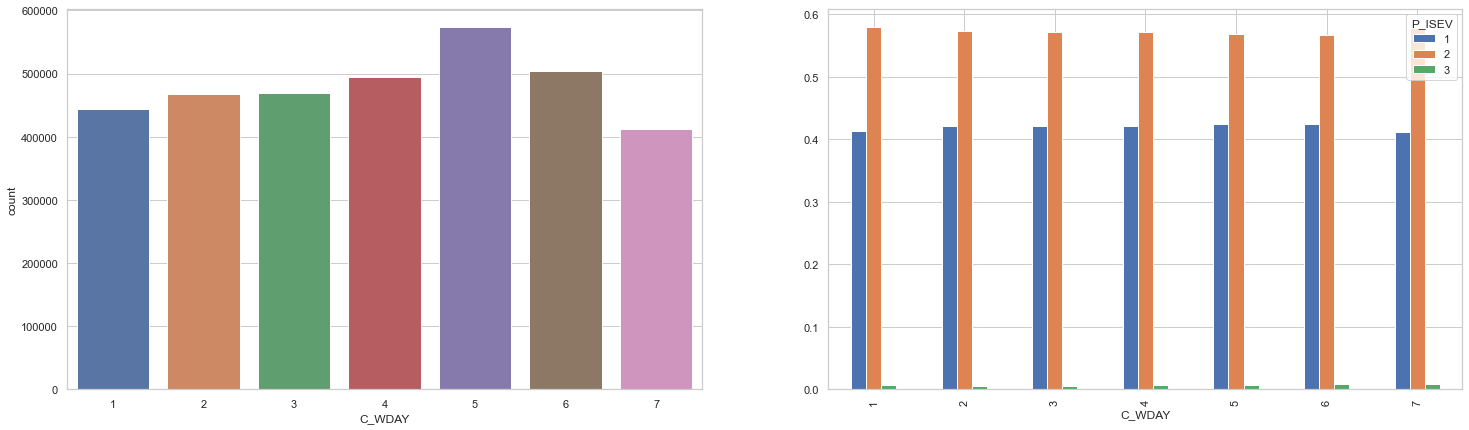

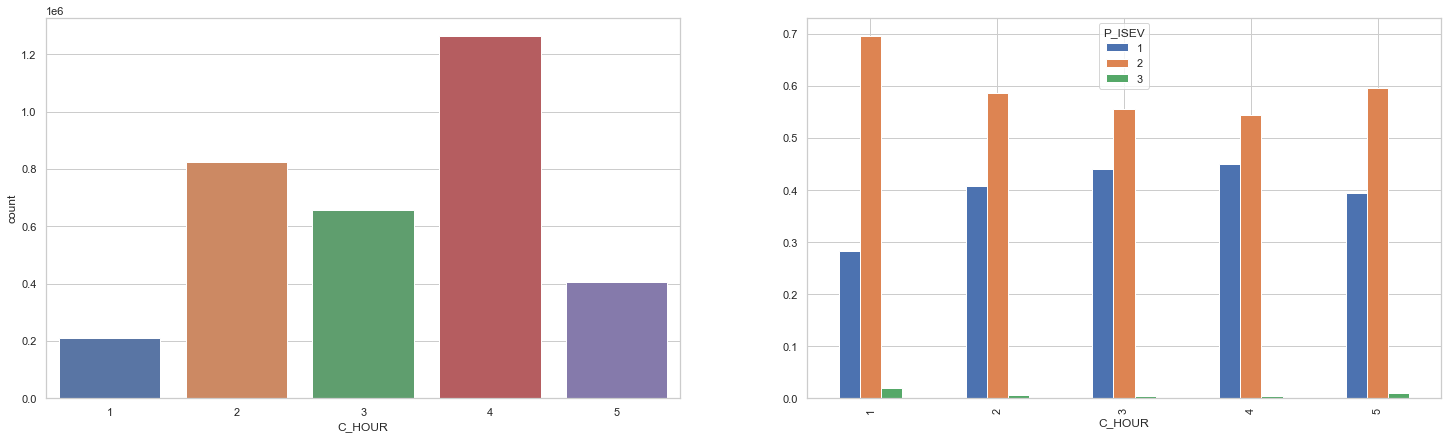

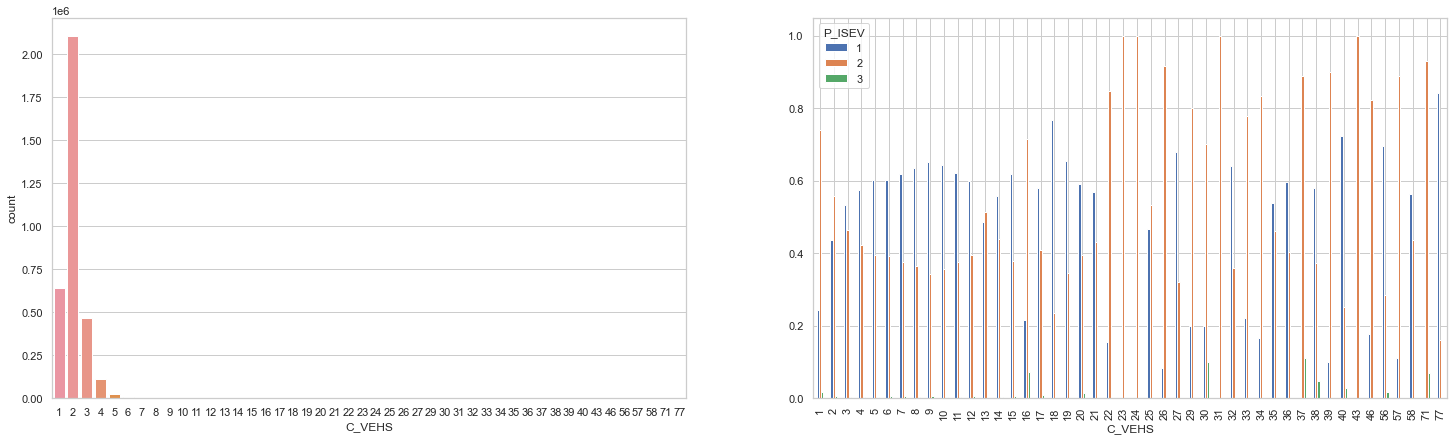

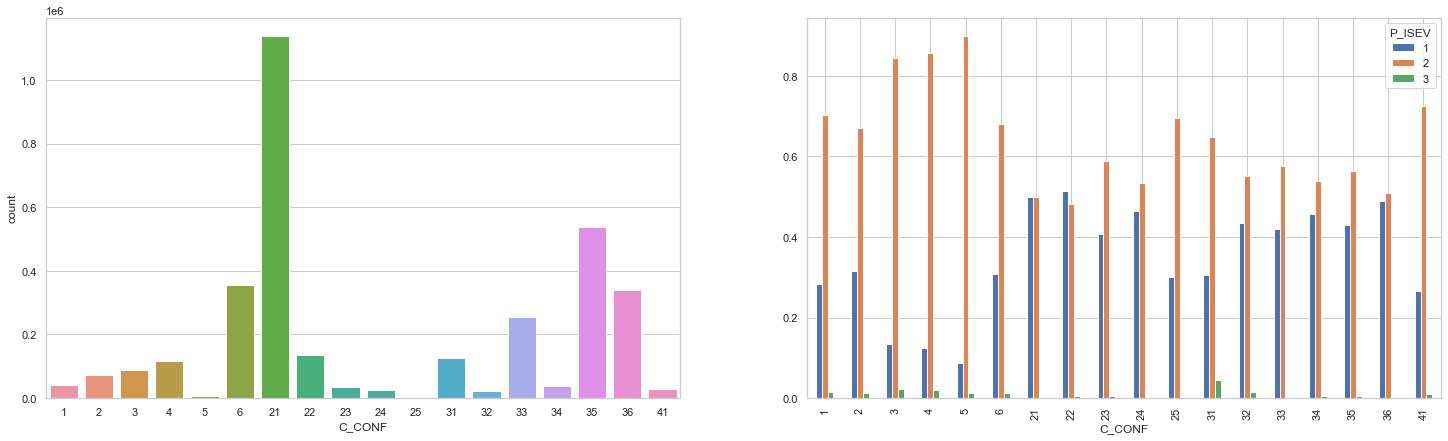

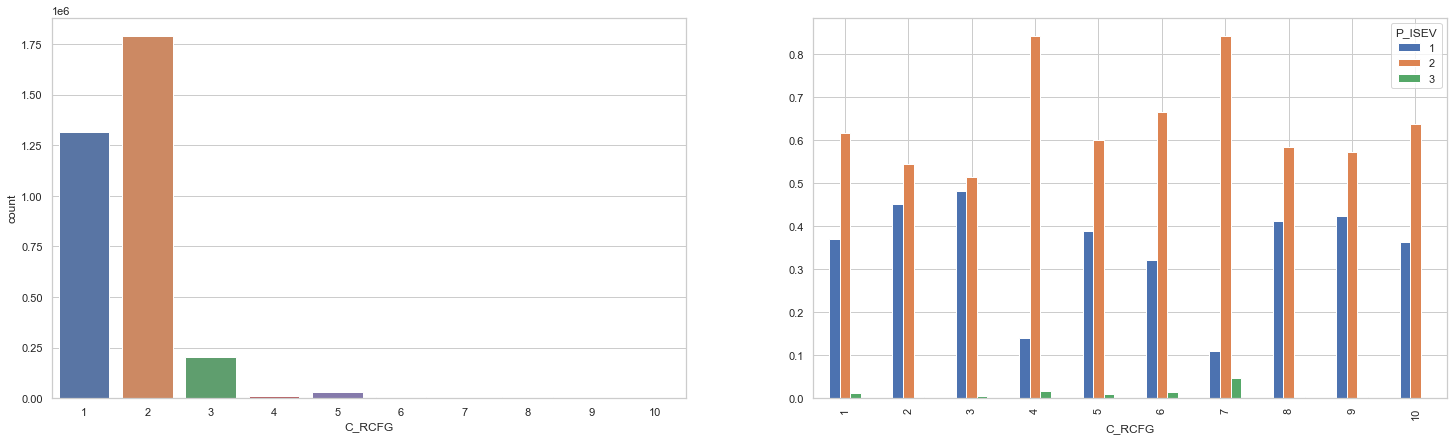

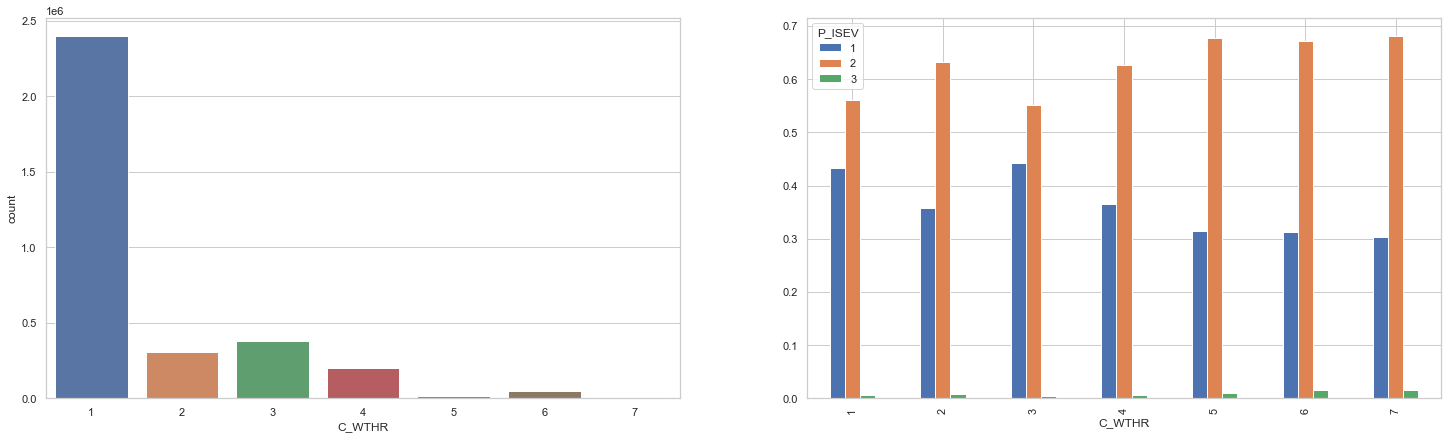

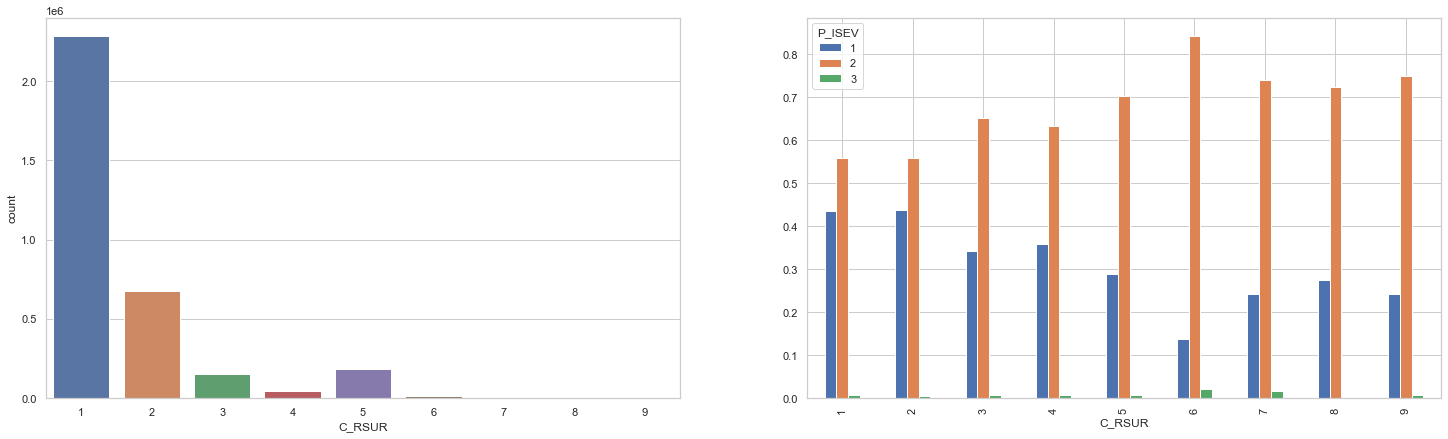

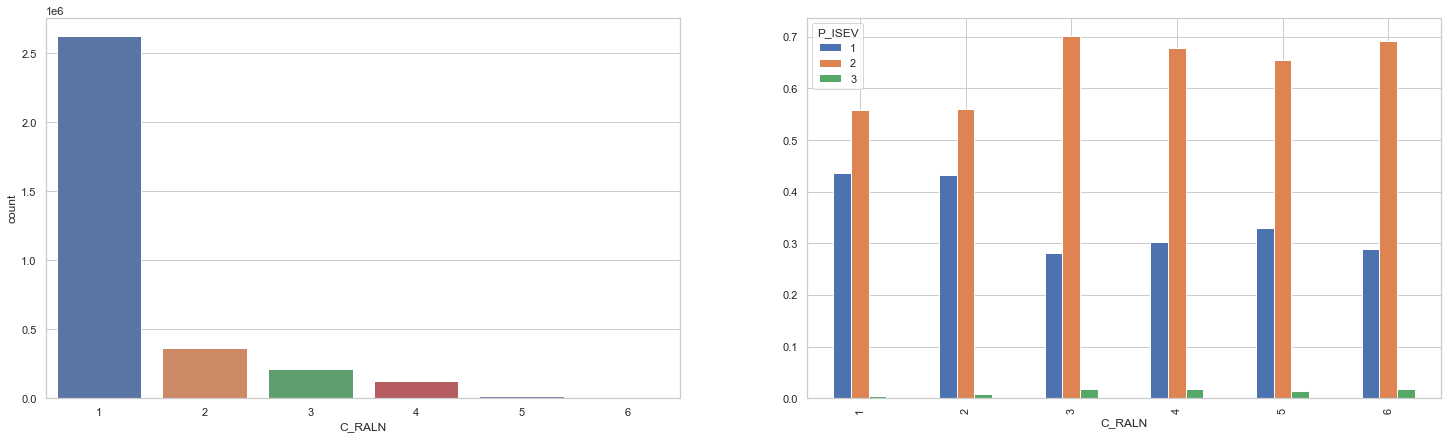

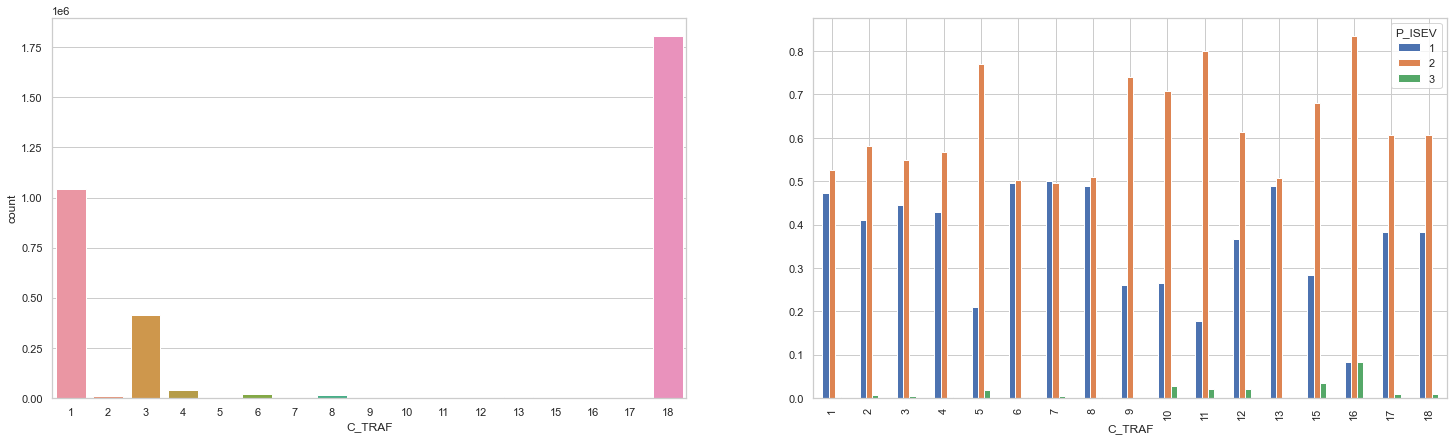

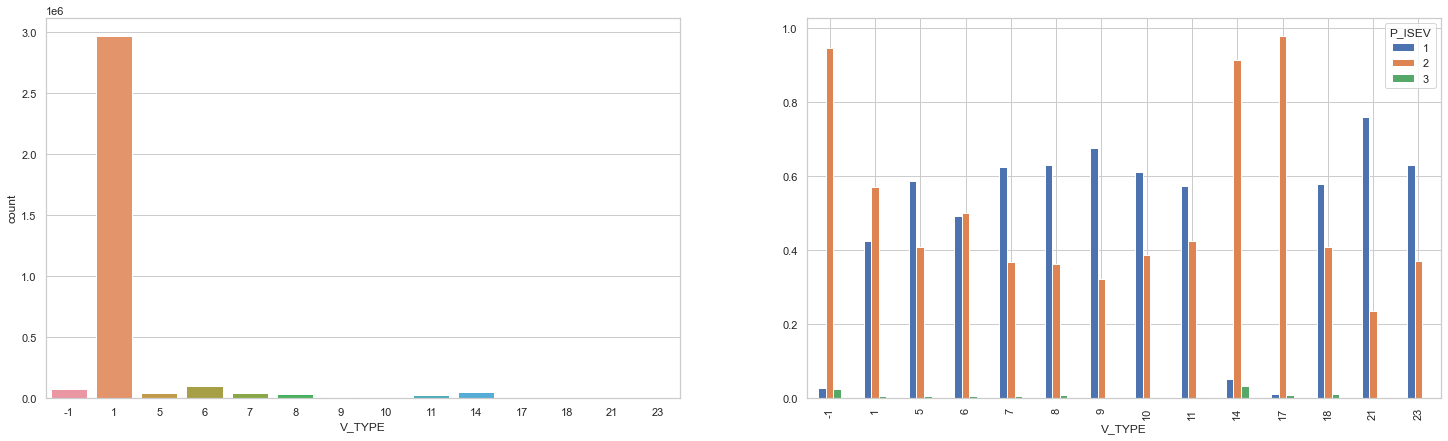

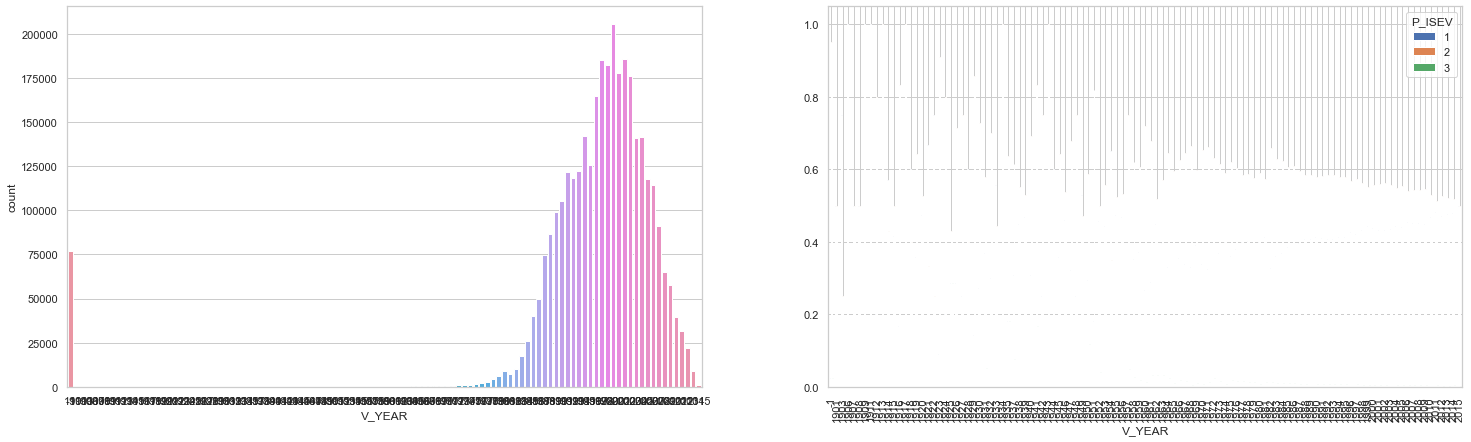

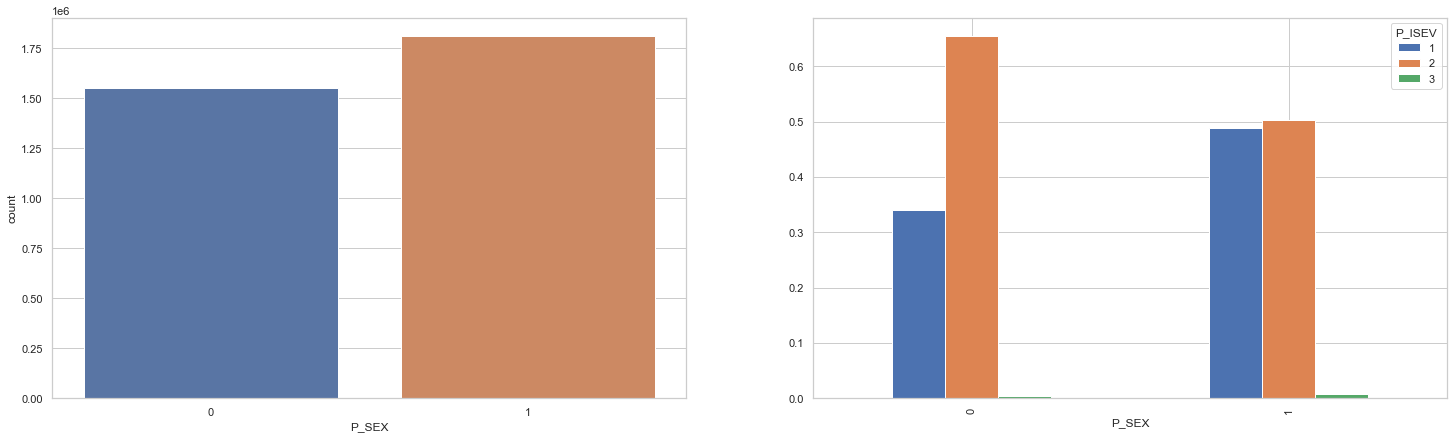

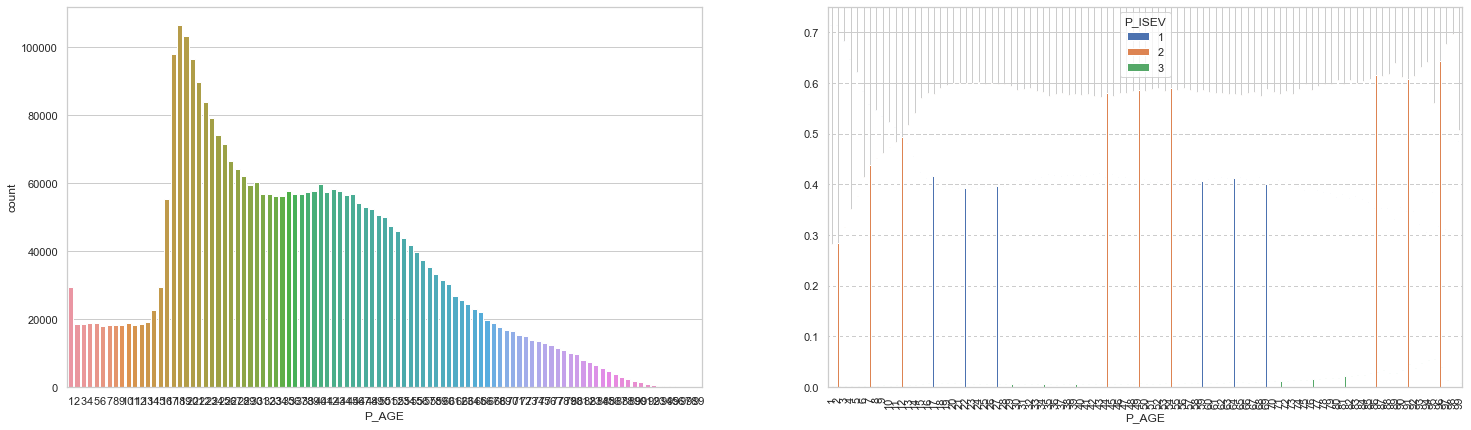

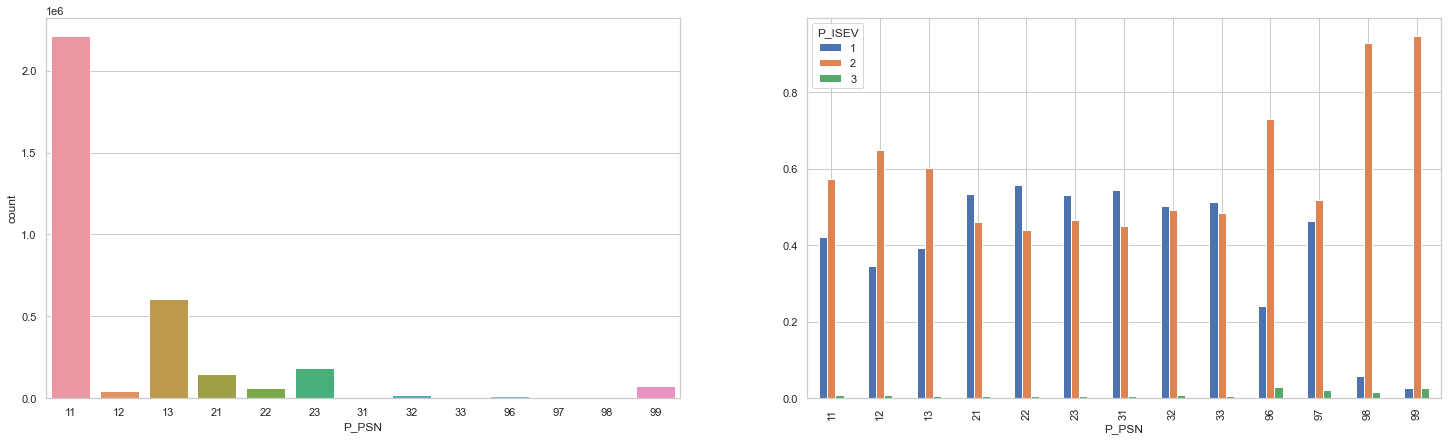

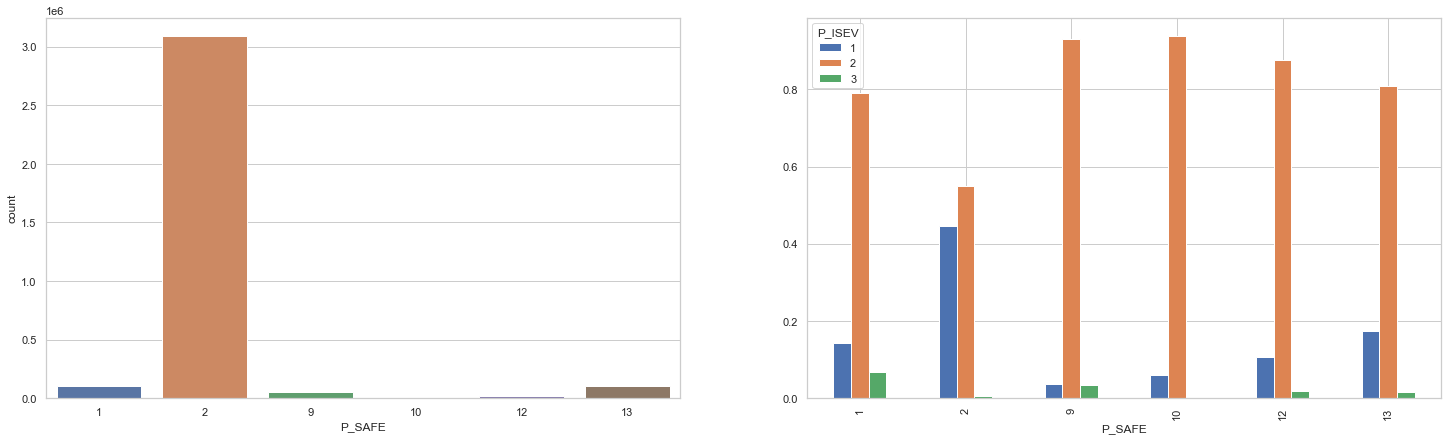

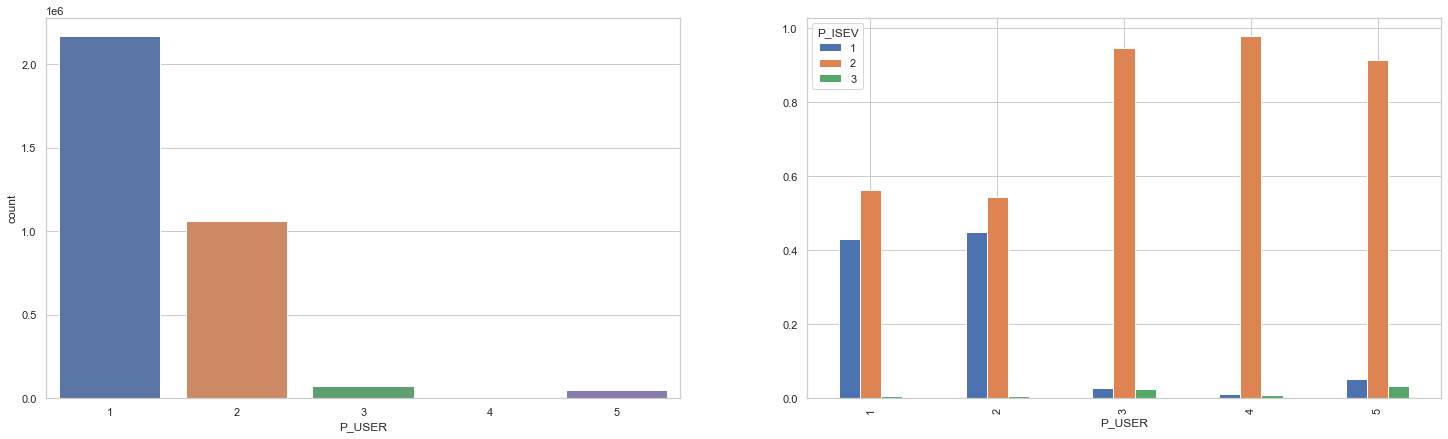

In [32]:
df_pisev = df.drop('C_SEV', axis=1)
for i in list(df_pisev.columns):
    if  i!='P_ISEV':
        plot_f(col_name=i, target='P_ISEV')

#### Transformación de las variables

Transformaremos algunas variables para disminuir el número de categorías, con la intención de mejorar la eficacia del aprendizaje.

- ***C_MNTH***

Veamos primero en que meses hubo más accidentes a traves del gráfico siguiente:

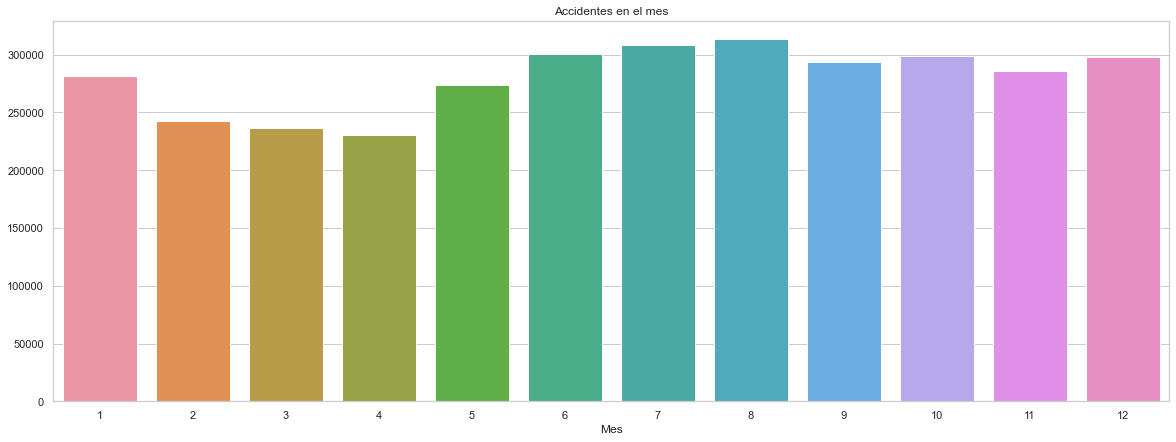

In [33]:
df_m = df.groupby('C_MNTH').size()

sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_m.index, y=df_m.values)
ax.set(xlabel="Mes", title='Accidentes en el mes')

plt.show()

Observamos que durante los meses de Febrero, Marzo y Abril hubo menos accidentes mortales que el resto de meses. Por lo tanto, podemos dividir los meses por cuatrimestres:

- **1**: Enero, Febrero, Marzo y Abril.
- **2**: Mayo, Junio, Julio y Agosto.
- **3**: Septiempre, Octubre, Noviembre y Diciembre.

In [34]:
df['C_MNTH'] = df['C_MNTH'].replace(dict.fromkeys([1,2,3,4], 1))
df['C_MNTH'] = df['C_MNTH'].replace(dict.fromkeys([5,6,7,8], 2))
df['C_MNTH'] = df['C_MNTH'].replace(dict.fromkeys([9,10,11,12], 3))

In [35]:
df['C_MNTH'].value_counts()

2    1196057
3    1176332
1     990853
Name: C_MNTH, dtype: int64

- ***C_VEHS***

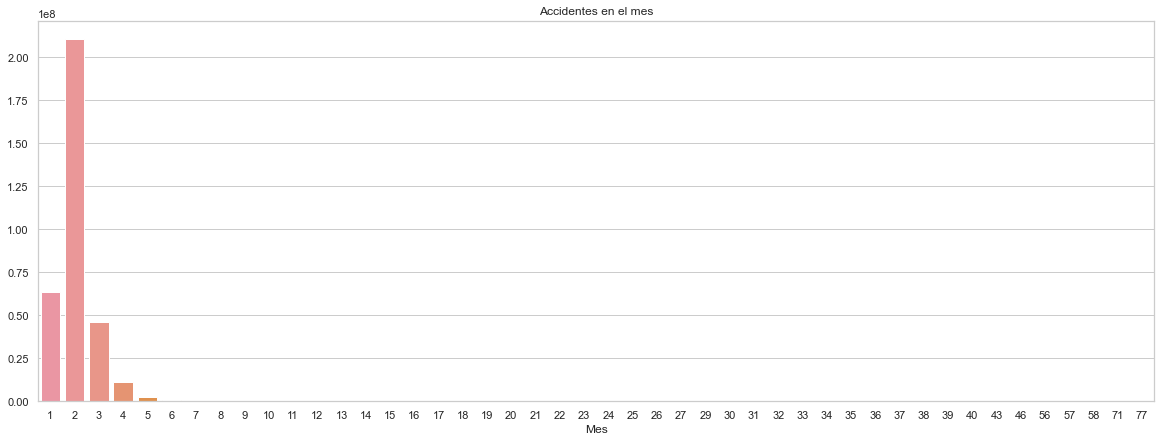

In [36]:
df_vh = df.groupby('C_VEHS').size()*100

sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_vh.index, y=df_vh.values)
ax.set(xlabel="Mes", title='Accidentes en el mes')

plt.show()

También podemos ver el número de vehículos que hay implicados en un accidente. en el gráfico veremos cuantas victimas mortales hay por cada accidente según el número de coches implicados:

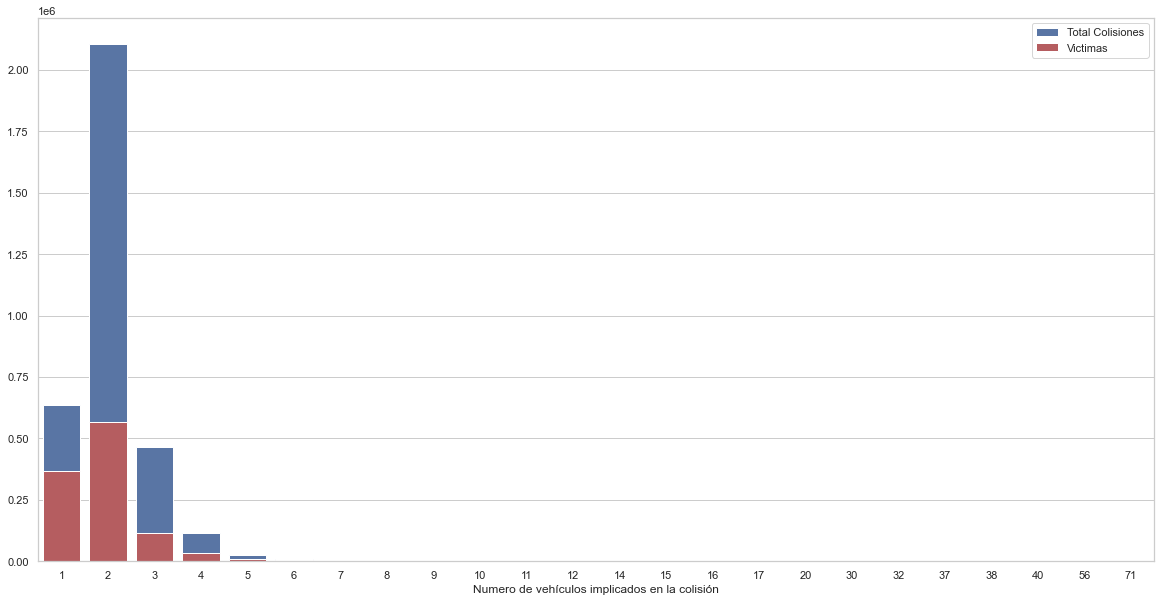

In [37]:
df_v1 = df.groupby('C_VEHS').size()
df_v2 = df[df['C_SEV']==1].groupby('C_VEHS').size()*20
ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(x=df_v1.index, y=df_v1.values, color='b', label='Total Colisiones')
ax = sns.barplot(x=df_v2.index, y=df_v2.values, color='r', label='Victimas')
ax.set(xlabel="Numero de vehículos implicados en la colisión")
ax.legend()

plt.show()

Como se trata de una variable con gran cantidad de valores distintos pero con muy pocas observaciones en los valores más altos,vamos a agrupar los valores de la siguiente forma:

- **1**: 1 vehículo implicado.
- **2**: 2 vehículos implicados.
- **3**: de 3 a 5 vehículos implicados.
- **4**: más de 5 vehículos implicados.

In [38]:
df['C_VEHS'].loc[(df['C_VEHS']>=3) & (df['C_VEHS']<=5)] =3
df['C_VEHS'].loc[df['C_VEHS'] > 5] = 4         
df['C_VEHS'] = df['C_VEHS'].astype('category') 

In [39]:
df['C_VEHS'].value_counts()

2    2106479
1     637759
3     603084
4      15920
Name: C_VEHS, dtype: int64

- ***C_RSUR***

Una variable a tener en cuenta es el estado de la superficie de la carretera, procediendo del mismo modo que antes:

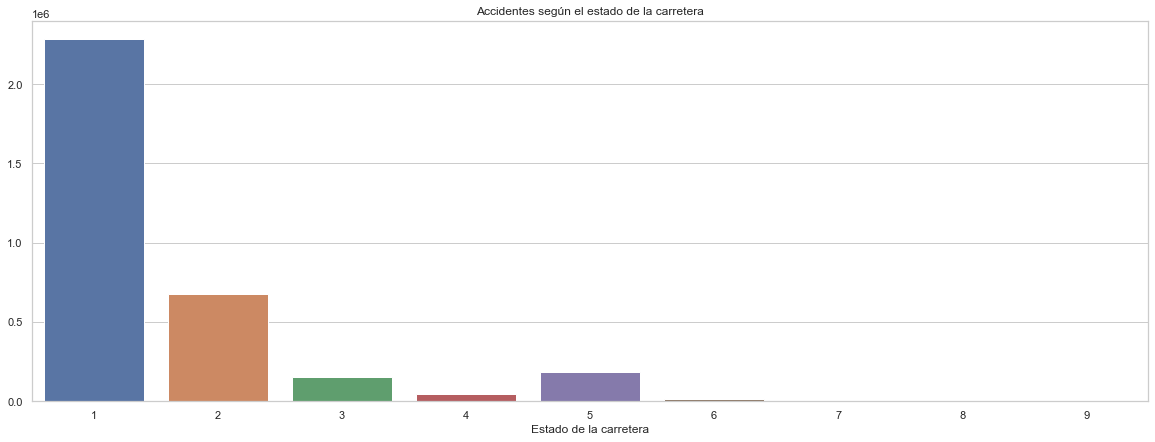

In [40]:
df_r = df.groupby('C_RSUR').size()

ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_r.index, y=df_r.values)
ax.set(xlabel="Estado de la carretera", title='Accidentes según el estado de la carretera')

plt.show()

A continuación agrupamos las variables:

- **1**: seca.
- **2**: mojada.
- **3**: nevada o helada.
- **4**: con arena, embarrada, con aceite o inundada.

In [41]:
df['C_RSUR'] = df['C_RSUR'].replace(dict.fromkeys([3,4,5], 3))
df['C_RSUR'] = df['C_RSUR'].replace(dict.fromkeys([6,7,8,9], 4))

In [42]:
df['C_RSUR'].value_counts()

1    2285834
2     678137
3     381074
4      18197
Name: C_RSUR, dtype: int64

- ***V_YEAR***

Para ver el número de accidentes según los años que tiene el modelo del vehículo lo haremos con la siguiente gráfica:

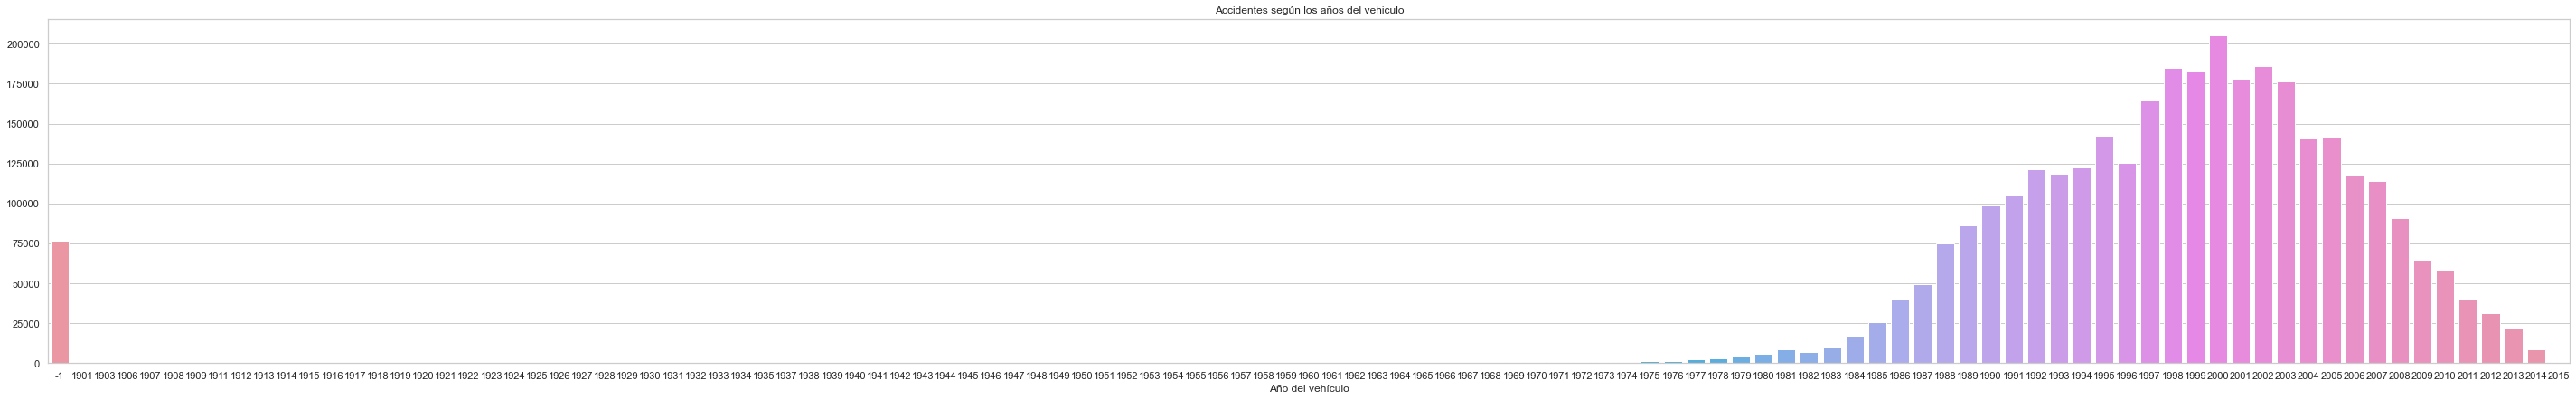

In [43]:
df_y = df.groupby('V_YEAR').size()
ax = plt.subplots(figsize = (50,7))
ax = sns.barplot(x=df_y.index, y=df_y.values)
ax.set(xlabel="Año del vehículo", title='Accidentes según los años del vehiculo')

plt.show()

Notamos que los vehículos de los años 1900 hasta los años 1970 no tienen ninguna observación, para ver mejor los datos haremos el gráfico a partir del año 1970:  

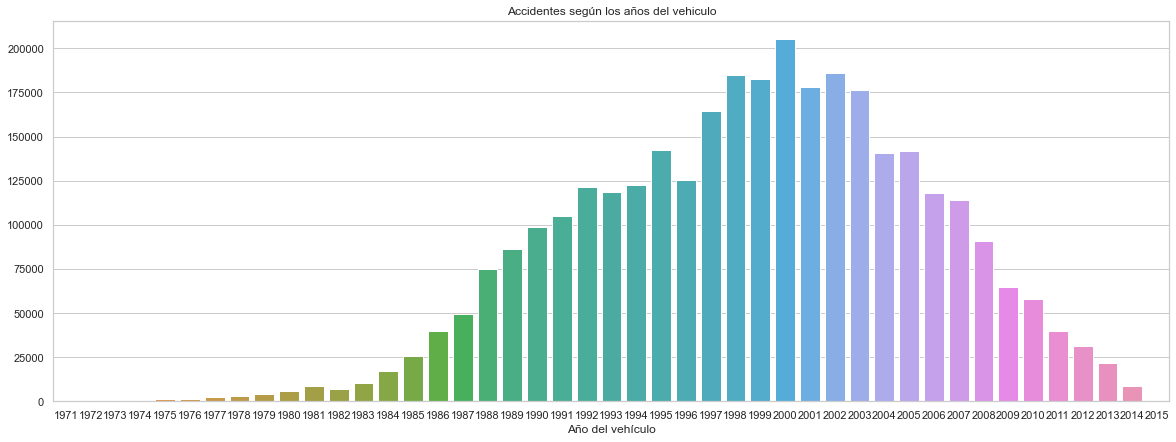

In [44]:
df_y = df[df['V_YEAR']>1970]
df_y1 = df_y.groupby('V_YEAR').size()
ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_y1.index, y=df_y1.values)
ax.set(xlabel="Año del vehículo", title='Accidentes según los años del vehiculo')

plt.show()

Según el gráfico que hemos obtenido, decidimos agrupar los datos de la forma siguiente:

- **-1**: peatones
- **1**: vehículos entre los años 1970 - 1989. 
- **2**: vehículos entre los años 1990 - 2000.
- **3**: vehículos entre los años 2001 - 2014.

In [45]:
df['V_YEAR'].loc[df['V_YEAR'] > 2000] = 3    
df['V_YEAR'].loc[df['V_YEAR'] >= 1990] = 2 
df['V_YEAR'].loc[df['V_YEAR'] >= 1900] = 1
df['V_YEAR'] = df['V_YEAR'].astype('category') 

In [46]:
df['V_YEAR'].value_counts()

 2    1571629
 3    1371038
 1     343868
-1      76707
Name: V_YEAR, dtype: int64

- ***P_AGE***

Para ver las edades de las personas que sufrieron accidentes, hacemos el gráfico:  

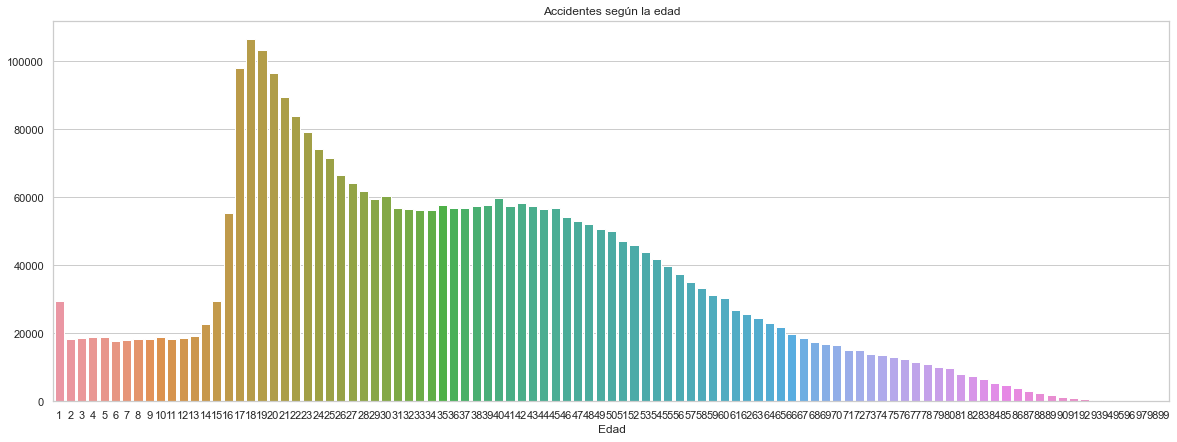

In [47]:
df_a = df.groupby('P_AGE').size()
ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_a.index, y=df_a.values)
ax.set(xlabel="Edad", title='Accidentes según la edad')

plt.show()

En la siguiente gráfica observamos que a partir de los 17 años hay un aumento en el número de accidentes y disminuyendo a partir de los 20 años.

Por lo que hemos decidido transformar la variable `P_AGE` del siguiente modo:

- **1**: Niños y adolescentes (de 0 años a 16 años).
- **2**: Jóvenes (de 17 años a 29 años).
- **3**: Adultos (de 30 años a 59 años)
- **4**: Personas mayores (de 60 años a 70 años)
- **5**: Personas mayores con más riesgo (a partir de los 71 años)

In [48]:
df['P_AGE'].loc[(df['P_AGE']< 17)] = 1       
df['P_AGE'].loc[(df['P_AGE']>= 17) & (df['P_AGE']< 30)] = 2  
df['P_AGE'].loc[(df['P_AGE']>= 30) & (df['P_AGE']< 60)] = 3  
df['P_AGE'].loc[(df['P_AGE']>= 60) & (df['P_AGE']<= 70)] = 4  
df['P_AGE'].loc[(df['P_AGE']> 70)] = 5  
df['P_AGE'] = df['P_AGE'].astype('category')

In [49]:
df['P_AGE'].value_counts()

3    1534565
2    1055036
1     359600
4     241329
5     172712
Name: P_AGE, dtype: int64

- ***P_PSN***

Si deseamos ver el número de accidentes según la posición en la que se encuentran los pasajeros, haremos lo siguiente:

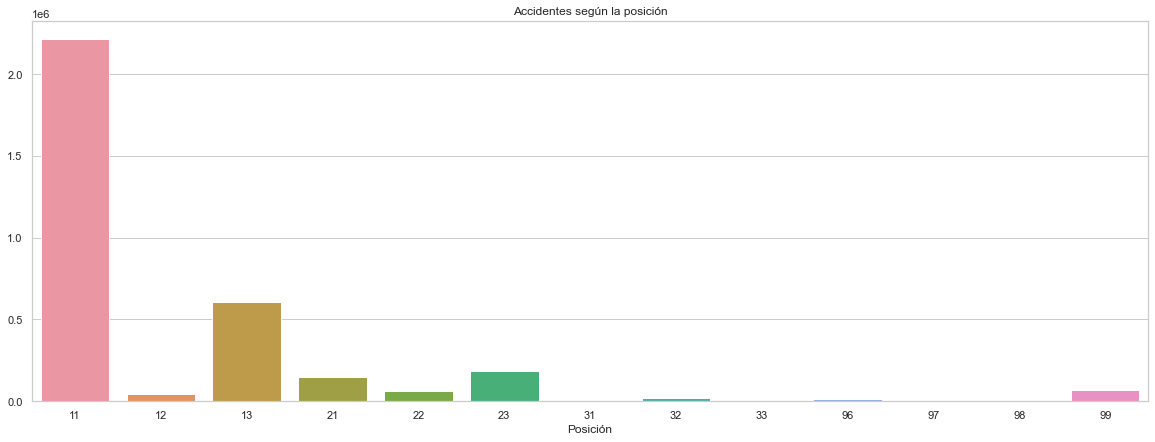

In [50]:
df_p = df.groupby('P_PSN').size()

ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_p.index, y=df_p.values)
ax.set(xlabel="Posición", title='Accidentes según la posición')

plt.show()

Para agrupar las posiciones lo haremos por filas:
    
- **1**: primera fila.
- **2**: segunda fila.
- **3**: tercera fila.
- **4**: otros puestos.
- **5**: peatones

In [51]:
df['P_PSN'] = df['P_PSN'].replace(dict.fromkeys([11,12,13], 1))  
df['P_PSN'] = df['P_PSN'].replace(dict.fromkeys([21,22,23], 2))
df['P_PSN'] = df['P_PSN'].replace(dict.fromkeys([31,32,33], 3))
df['P_PSN'] = df['P_PSN'].replace(dict.fromkeys([96,97,98], 4))  
df['P_PSN'] = df['P_PSN'].replace(dict.fromkeys([99], 5)) 

In [52]:
df['P_PSN'].value_counts()

1    2865312
2     391917
5      71562
3      22917
4      11534
Name: P_PSN, dtype: int64

- ***P_ISEV***

Esta variable hace referencia al requerimiento de tratamiento médico, toma los valores:

1. Si el accidentado resultó ileso
2. Si el accidentado resultó herido
3. Si el accidentado ha fallecido.

In [53]:
df['P_ISEV'].value_counts()

2    1926838
1    1413395
3      23009
Name: P_ISEV, dtype: int64

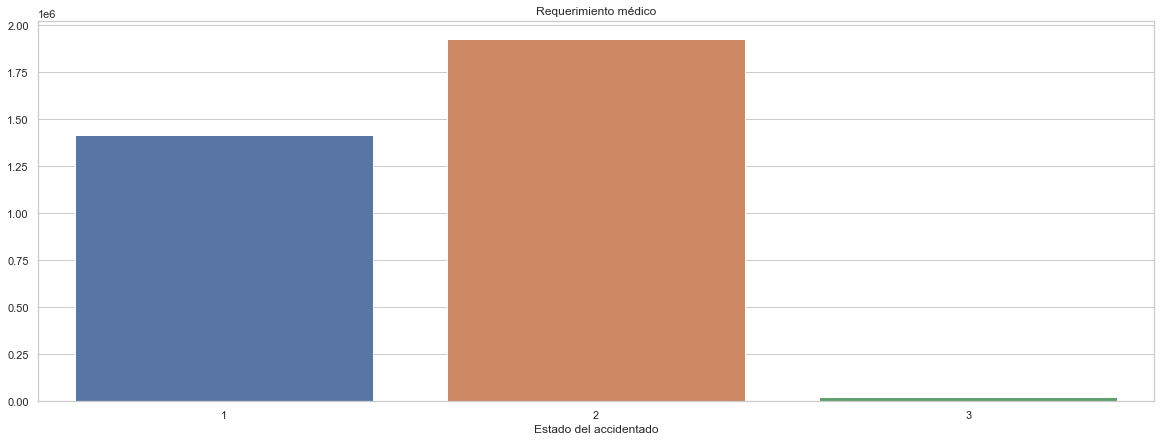

In [54]:
df_p = df.groupby('P_ISEV').size()

ax = plt.subplots(figsize = (20,7))
ax = sns.barplot(x=df_p.index, y=df_p.values)
ax.set(xlabel="Estado del accidentado", title='Requerimiento médico')

plt.show()

Agruparemos los datos de la siguiente forma: 
    
- **0**: si resultó herido.
- **1**: si ha fallecido.

In [55]:
df['P_ISEV'] = np.where(df['P_ISEV'] == 2, 1, np.where(df['P_ISEV'] == 3, 1, 0))

#### Matriz de correlaciones

In [56]:
df = df.drop(['C_YEAR'],axis=1)
df_int = df.astype('int64')

- ***C_SEV***

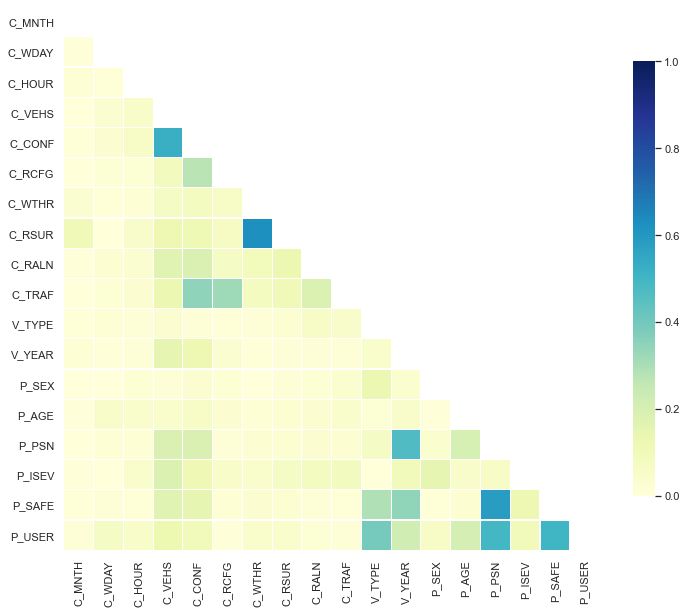

In [57]:
corr = np.abs(df_int.drop(['C_SEV'], axis=1).corr())

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

Por el mapa vemos que la correlación más alta es entre `C_RSUR` y `C_WTHR`, la cual es:

In [58]:
corr.iloc[6,7]

0.6270497575758986

- ***P_ISEV***

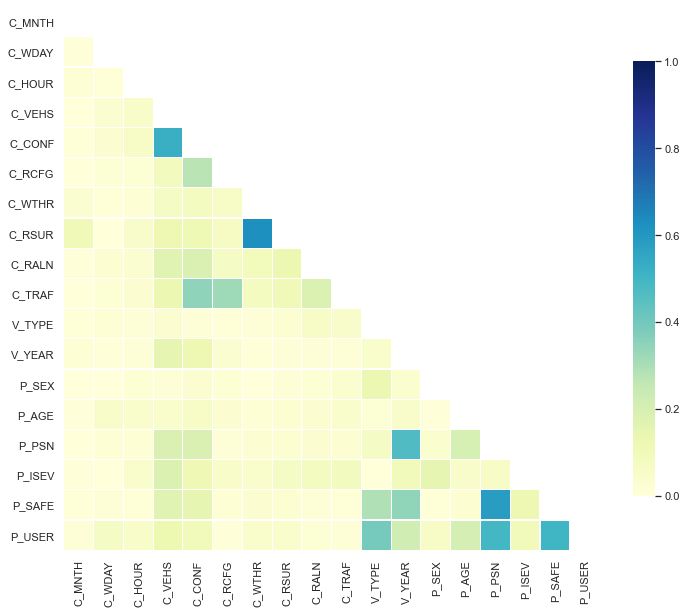

In [59]:
corr2 = np.abs(df_int.drop(['P_ISEV'], axis=1).corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

In [60]:
corr2.iloc[7,8]

0.6270497575758986

#### Particionado del conjunto de datos

- ***C_SEV***

In [61]:
Counter(df['C_SEV'])

Counter({2: 3307607, 1: 55635})

<AxesSubplot:>

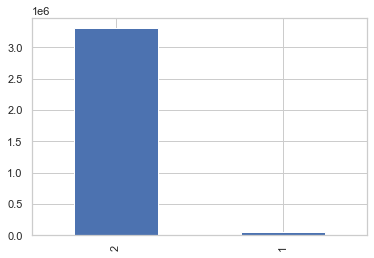

In [62]:
df['C_SEV'].value_counts().plot.bar()

In [63]:
rus = RandomUnderSampler(random_state = 0)
rus.fit_resample(df.drop('C_SEV', axis = 1), df[['C_SEV']])
print('Nos quedaremos con', len(rus.sample_indices_),'filas')

Nos quedaremos con 111270 filas


<AxesSubplot:>

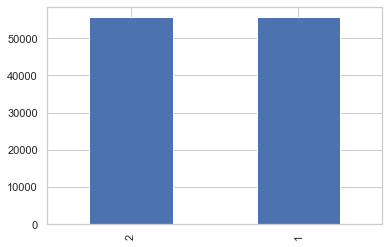

In [64]:
df_b = df.iloc[rus.sample_indices_]
df_b['C_SEV'].value_counts().plot.bar()

- ***P_ISEV***

In [65]:
Counter(df['P_ISEV'])

Counter({1: 1949847, 0: 1413395})

<AxesSubplot:>

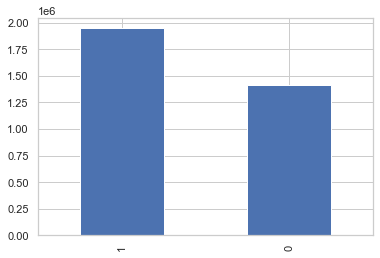

In [66]:
df['P_ISEV'].value_counts().plot.bar()

La cantidad de heridos y no heridos en accidentes de tráfico es similar, por lo que no será necesario aplicar técnicas de balanceo.

Después de balancear la variable objetivo se separan los datos en un conjunto de entrenamiento, con un 80% de estos, y en un conjunto de test, con un 20%.

- ***C_SEV***

In [67]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df_b.drop(['C_SEV','P_ISEV'],axis=1), 
                                                        df_b['C_SEV'], stratify=df_b['C_SEV'], test_size=0.2)

train_set_s = pd.concat([X_train_s, y_train_s],axis=1)
test_set_s = pd.concat([X_test_s, y_test_s],axis=1)


X_train, X_test, y_train, y_test = train_test_split(df.drop(['C_SEV','P_ISEV'],axis=1), 
                                                        df['C_SEV'], stratify=df['C_SEV'], test_size=0.2)

train_set = pd.concat([X_train, y_train],axis=1)
test_set = pd.concat([X_test, y_test],axis=1)

#### Preparación del conjunto de datos 

In [68]:
ohe = ce.OneHotEncoder(cols=X_train_s.columns)
model = ohe.fit(X_train_s,y_train_s)

X_train_s = model.transform(X_train_s,y_train_s)
X_test_s = model.transform(X_test_s,y_test_s)

In [69]:
X_train_s.dtypes

C_MNTH_1    int64
C_MNTH_2    int64
C_MNTH_3    int64
C_WDAY_1    int64
C_WDAY_2    int64
            ...  
P_USER_1    int64
P_USER_2    int64
P_USER_3    int64
P_USER_4    int64
P_USER_5    int64
Length: 121, dtype: object

In [70]:
X_train = model.transform(X_train,y_train)
X_test = model.transform(X_test,y_test)

In [71]:
X_train.dtypes

C_MNTH_1    int64
C_MNTH_2    int64
C_MNTH_3    int64
C_WDAY_1    int64
C_WDAY_2    int64
            ...  
P_USER_1    int64
P_USER_2    int64
P_USER_3    int64
P_USER_4    int64
P_USER_5    int64
Length: 121, dtype: object

- ***P_ISEV***

In [72]:
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(df_b.drop(['C_SEV','P_ISEV'],axis=1), 
                                                        df_b['P_ISEV'], stratify=df_b['P_ISEV'], test_size=0.2)

train_set_sp = pd.concat([X_train_sp, y_train_sp],axis=1)
test_set_sp = pd.concat([X_test_sp, y_test_sp],axis=1)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df.drop(['C_SEV','P_ISEV'],axis=1), 
                                                                     df['P_ISEV'], stratify=df['P_ISEV'], test_size=0.2)
train_p = pd.concat([X_train_p, y_train_p],axis=1)
test_p = pd.concat([X_test_p, y_test_p],axis=1)

#### Preparación del conjunto de datos 

In [73]:
ohe = ce.OneHotEncoder(cols=X_train_sp.columns)
model = ohe.fit(X_train_sp,y_train_sp)

X_train_sp = model.transform(X_train_sp,y_train_sp)
X_test_sp = model.transform(X_test_sp,y_test_sp)

In [74]:
X_train_p = model.transform(X_train_p,y_train_p)
X_test_p = model.transform(X_test_p, y_test_p)

### 4. ALGORITMOS DE CLASIFICACIÓN

#### Fallecidos/No Fallecidos (C_SEV)

- **Regresión logística**

best mean cross-validation score: 0.752
best parameters: {'C': 1.9952623149688788}


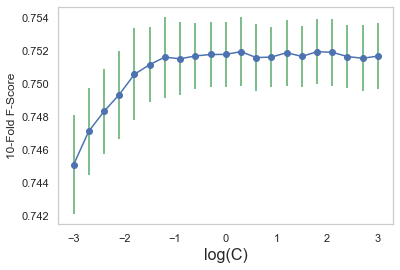

In [75]:
vectorC = np.logspace(-3,3,21)

param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(X_train_s, y_train_s)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold F-Score')
plt.grid()
plt.show()

In [76]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt).fit(X_train_s, y_train_s)

y_pred = lr.predict(X_test_s)
y_pred2 = lr.predict(X_test)
y_prob = lr.predict_proba(X_test_s)

print("Accuracy de entrenamiento para datos balanceados",lr.score(X_train_s, y_train_s))
print("Accuracy de test para datos balanceados: ",lr.score(X_test_s,y_test_s))
print("Accuracy de test para datos originales: ",lr.score(X_test,y_test))

LRAcc = accuracy_score(y_pred2,y_test)

Accuracy de entrenamiento para datos balanceados 0.757897456637009
Accuracy de test para datos balanceados:  0.7546957850274107
Accuracy de test para datos originales:  0.7772270530395496


La **exactitud** representa el porcentaje de predicciones correctas frente al total. En nuestro caso, obtenemos una exactitud del **77.72%** para los datos originales, y del **75.46%** para el caso de los datos balanceados.

In [77]:
# Función auxiliar para la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(y_t, y_p):
    cm = confusion_matrix(y_t, y_p) 
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    sns.set_style('white')
    cm_display.plot()
    plt.show()

In [78]:
# Función auxiliar para las méticas 
def metricas(y_t,y_p):
    cm = confusion_matrix(y_t, y_p) 
    total=sum(sum(cm))

    accuracy=(cm[0,0]+cm[1,1])/total
    print ('Accuracy : ', accuracy)

    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Sensitivity : ', sensitivity )

    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Specificity : ', specificity)

    positive_predictive_value = cm[1,1]/(cm[0,1]+cm[1,1])
    print('Positive Predictive Value : ' , positive_predictive_value)

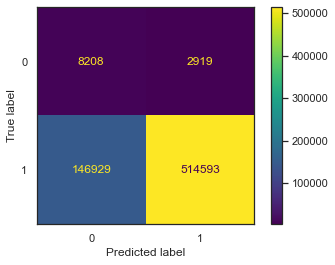

Accuracy :  0.7772270530395496
Sensitivity :  0.7376651388514425
Specificity :  0.7778924963946777
Positive Predictive Value :  0.9943595510828734


In [79]:
conf_matrix (y_test, y_pred2) 
metricas(y_test, y_pred2)

Para los datos originales, la matriz de confusión nos indica que cuenta con 8208 datos  verdadeos positivos (datos que eran 0 y el modelo los predijo correctamente).

A parte, tenemos 514593 datos verdaderos negativos (datos que eran 1 y el modelo los predijo correctamente).

Si analizamos los datos que el modelo no ha predicho bien. Los datos falsos positivos, en total fueron 146929, esto quiere decir que eran 0 pero el modelo los predijo como 1. En cuanto a los falsos negativos, tenemos 2919, que eran en realidad 1 y el modelo los predijo como 0.

Además, hemos obtenidos en las métricas del modelo. Referente a los valores: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **73.76%**, un resultado bastante alto por lo que el modelo es bastante sensible, predice correctamente muchos positivos, esto significa que el modelo es capaz de identificar el 80% de accidentes con víctimas mortales. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **77.89%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **99.43%**, por lo que nuestro modelo escogido detecta correctamente en un gran número de casos.

- **Árbol de decisión**

best mean cross-validation score: 0.754
best parameters: {'max_depth': 12}


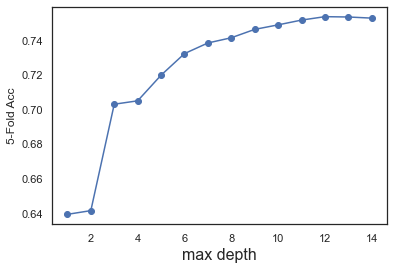

In [80]:
maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train_s, y_train_s)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

In [81]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(X_train_s, y_train_s)

y_pred = treeModel.predict(X_test_s)
y_pred2 = treeModel.predict(X_test)

print("Accuracy de entrenamiento para datos balanceados",treeModel.score(X_train_s, y_train_s))
print("Accuracy de test para datos balanceados: ",treeModel.score(X_test_s,y_test_s))
print("Accuracy de test para datos originales: ",treeModel.score(X_test,y_test))
DTAcc = accuracy_score(y_pred2,y_test)

Accuracy de entrenamiento para datos balanceados 0.7744225757167251
Accuracy de test para datos balanceados:  0.7533477127707379
Accuracy de test para datos originales:  0.7805051371517686


La **exactitud** es del **78.05%** para los datos originales y del **75.33%** para el caso de los datos balanceados. 

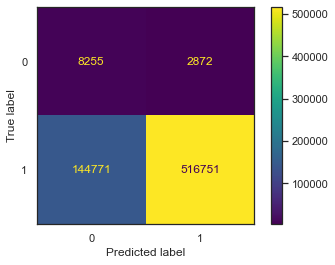

Accuracy :  0.7805051371517686
Sensitivity :  0.7418890985890177
Specificity :  0.781154670592966
Positive Predictive Value :  0.9944729159409803


In [82]:
conf_matrix (y_test, y_pred2) 
metricas(y_test, y_pred2)

La matriz indica que hay 8255 datos reales eran 0 y el modelo los predijo correctamente, 516751 unos predichos de forma adecuada, 144771 falsos positivos y 2872 falsos negativos.

 Referente a los valores de las métricas obtenidas: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **74.18%**, un resultado bastante alto por lo que el modelo es bastante sensible, predice correctamente muchos positivos, esto significa que el modelo es capaz de identificar el 80% de accidentes con víctimas mortales. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **78.11%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **99.44%**, por lo que nuestro modelo escogido detecta correctamente en un gran número de casos.

- **Random Forest**

best mean cross-validation score: 0.763
best parameters: {'max_depth': 13}


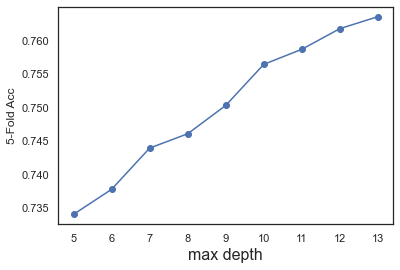

In [83]:
maxDepth = range(5,14)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(n_estimators = 20), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train_s, y_train_s)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

In [84]:
maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestClassifier(n_estimators = 20, max_depth=maxDepthOptimo).fit(X_train_s, y_train_s)

y_pred = rf.predict(X_test_s)
y_pred2 = rf.predict(X_test)

print("Accuracy de entrenamiento para datos balanceados",rf.score(X_train_s, y_train_s))
print("Accuracy de test para datos balanceados: ",rf.score(X_test_s,y_test_s))
print("Accuracy de test para datos originales: ",rf.score(X_test,y_test))

RFAcc = accuracy_score(y_pred2,y_test)

Accuracy de entrenamiento para datos balanceados 0.789554686797879
Accuracy de test para datos balanceados:  0.7619753752134448
Accuracy de test para datos originales:  0.7610908512463409


La **exactitud** es del **76.10%** para los datos originales y del **76.20%** para el caso de los datos balanceados. 

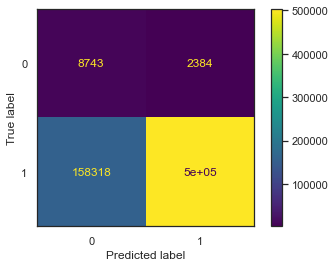

Accuracy :  0.7610908512463409
Sensitivity :  0.785746382672778
Specificity :  0.7606761377550557
Positive Predictive Value :  0.995284698212774


In [85]:
conf_matrix (y_test, y_pred2) 
metricas(y_test, y_pred2)

La matriz indica que hay 8743 datos reales eran 0 y el modelo los predijo correctamente, 5e$^5$ unos predichos de forma adecuada, 158318 falsos positivos y 2384 falsos negativos.

 Referente a los valores de las métricas obtenidas: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **78.57%**, un resultado bastante alto por lo que el modelo es bastante sensible, predice correctamente muchos positivos, esto significa que el modelo es capaz de identificar el 80% de accidentes con víctimas mortales. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **76.06%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **99.52%**, por lo que nuestro modelo escogido detecta correctamente en un gran número de casos.

Para hallar la importancia de las variables en el modelo podemos hacer lo siguiete:

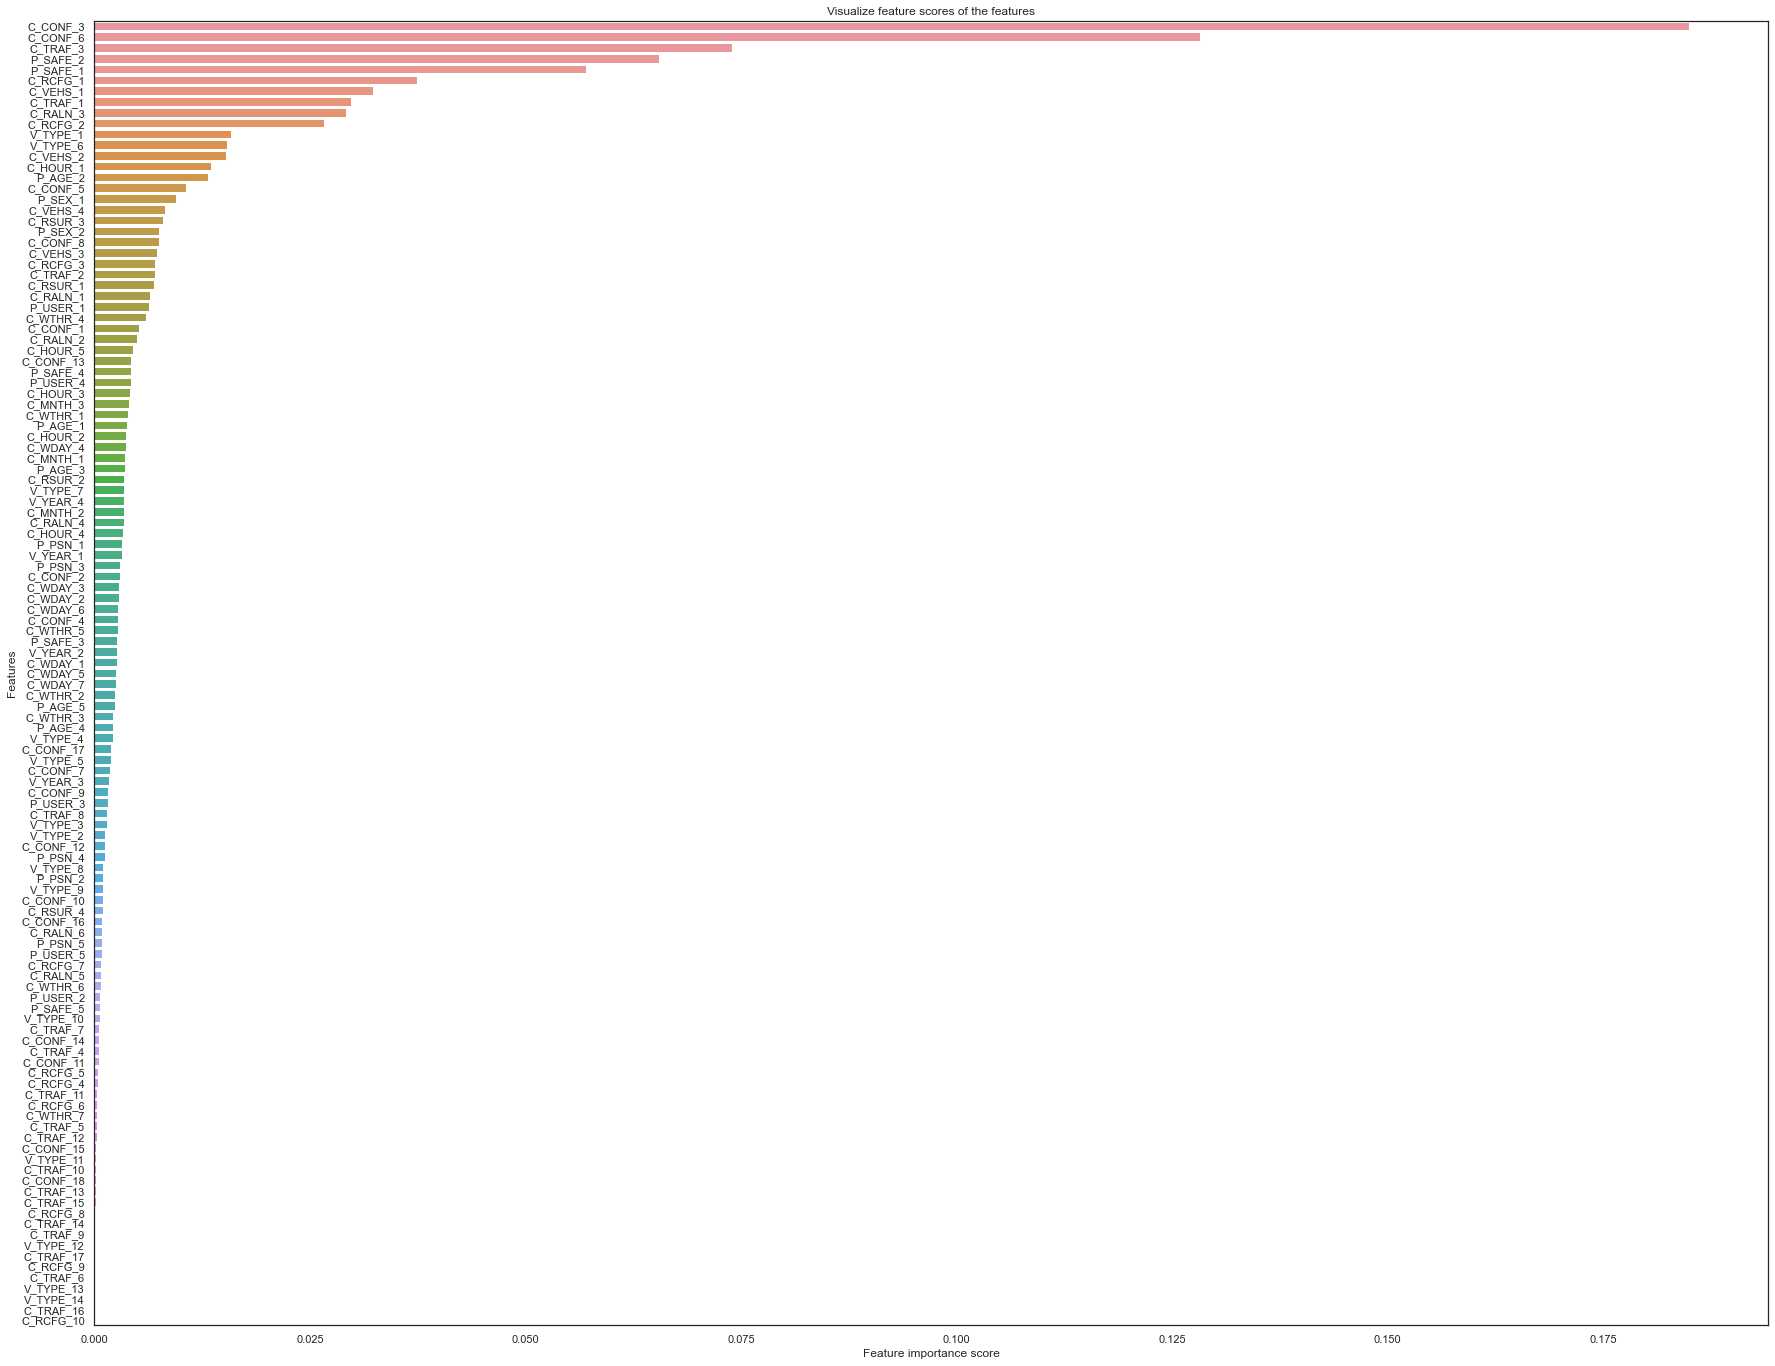

In [86]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [87]:
df['C_CONF'].dtypes

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 36,
                  41],
                 ordered=False)

Según la gráfica, la variable con más importancia a la hora de clasificar si una coalición produce o no fallecimiento es la configuración 3. A la hora de hacer onehotencoding, nos ha modificado los índices, ordenándolos directamente sin tener en cuenta las categorías iniciales.

Entonces ahora la `C_CONF_3` es la configuración número 3, si vamos a la leyenda, la mayoría de los accidentes con fallecimiento se producen por el propio vehículo, si se choca con un elemento estacionario.

- **Gradient Boost**

In [88]:
gbc = GradientBoostingClassifier(
              learning_rate=0.1,  max_depth=12,
              min_weight_fraction_leaf=0.02, n_estimators=130,
              random_state=2408,
              verbose=1)

gbc.fit(X_train_s, y_train_s)

      Iter       Train Loss   Remaining Time 
         1           1.3290            1.26m
         2           1.2819            1.27m
         3           1.2435            1.23m
         4           1.2105            1.23m
         5           1.1835            1.19m
         6           1.1597            1.18m
         7           1.1397            1.15m
         8           1.1229            1.14m
         9           1.1084            1.14m
        10           1.0959            1.13m
        20           1.0214            1.07m
        30           0.9911            1.02m
        40           0.9787           55.72s
        50           0.9714           50.34s
        60           0.9661           44.53s
        70           0.9614           38.32s
        80           0.9573           31.98s
        90           0.9542           25.59s
       100           0.9513           19.24s


GradientBoostingClassifier(max_depth=12, min_weight_fraction_leaf=0.02,
                           n_estimators=130, random_state=2408, verbose=1)

In [89]:
y_pred = gbc.predict(X_test_s)
y_pred2 = gbc.predict(X_test)

print("Accuracy de entrenamiento para datos balanceados",gbc.score(X_train_s, y_train_s))
print("Accuracy de test para datos balanceados: ",gbc.score(X_test_s,y_test_s))
print("Accuracy de test para datos originales: ",gbc.score(X_test,y_test))

GBAcc = accuracy_score(y_pred2, y_test)

Accuracy de entrenamiento para datos balanceados 0.7696593870764806
Accuracy de test para datos balanceados:  0.7624247326323358
Accuracy de test para datos originales:  0.7672768412649094


La **exactitud** es del **76.72%** para los datos originales y del **76.24%** para el caso de los datos balanceados. 

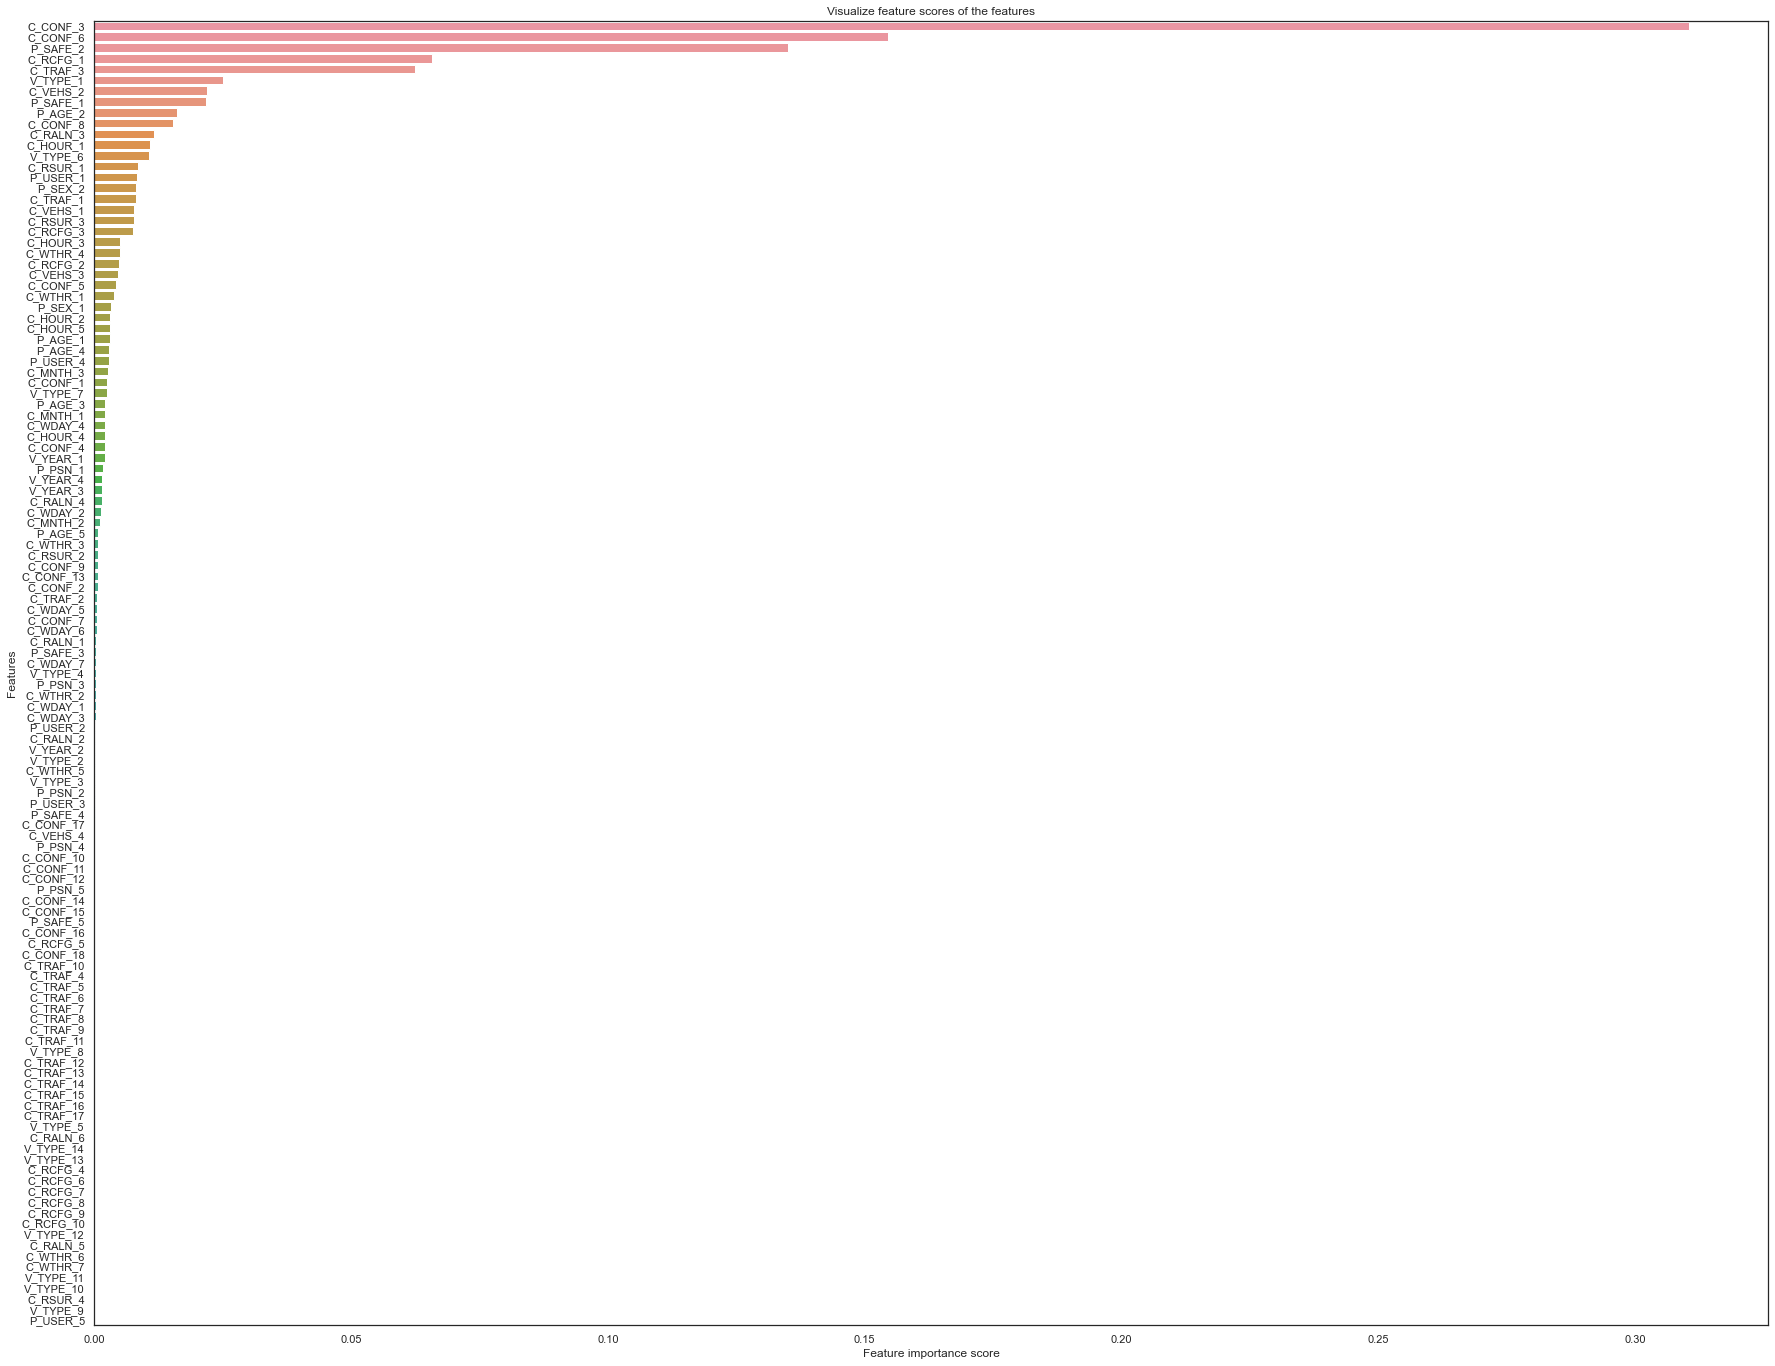

In [90]:
feature_scores = pd.Series(gbc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

Al igual que pasa en el modelo Random Forest, vemos que lo que más afecta a esta variable objetivo es `C_CONF_3`.

- **Comparación de los modelos**

In [91]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree','Random Forest','Gradient Boosting'], 
                        'Accuracy': [LRAcc*100, DTAcc*100,RFAcc*100,GBAcc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Decision Tree,78.050514
0,Logistic Regression,77.722705
3,Gradient Boosting,76.727684
2,Random Forest,76.109085


Comparando los modelos por el valor **accuracy** (exactitud), obtenemos que el algoritmo con mayor precisión es el **Árbol de decisión** con un **78.05%** en precisión. 

#### Clasificación Heridos/Sanos (P_ISEV)

- **Regresión Logística**

best mean cross-validation score: 0.824
best parameters: {'C': 0.003981071705534973}


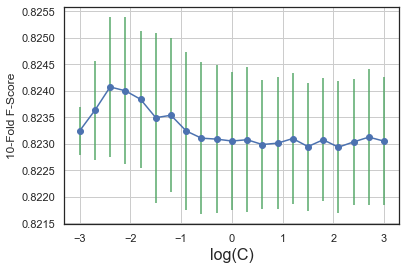

In [92]:
vectorC = np.logspace(-3,3,21)

param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(X_train_sp, y_train_sp)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold F-Score')
plt.grid()
plt.show()

In [93]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt).fit(X_train_sp, y_train_sp)

y_pred = lr.predict(X_test_sp)
y_pred2 = lr.predict(X_test_p)
y_prob = lr.predict_proba(X_test_sp)

print("Accuracy de entrenamiento para datos balanceados",lr.score(X_train_sp, y_train_sp))
print("Accuracy de test para datos balanceados: ",lr.score(X_test_sp,y_test_sp))
print("Accuracy de test para datos originales: ",lr.score(X_test_p,y_test_p))

LRAcc = accuracy_score(y_pred2,y_test_p)

Accuracy de entrenamiento para datos balanceados 0.730160869955963
Accuracy de test para datos balanceados:  0.7282286330547317
Accuracy de test para datos originales:  0.6381961468760081


La **exactitud** es del modelo es del **63.81%** para los datos originales y del **72.82%** para lod datos balanceados. 

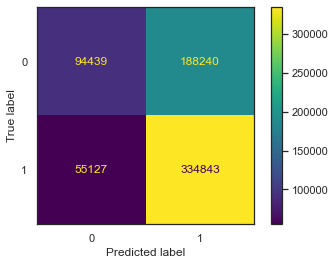

Accuracy :  0.6381961468760081
Sensitivity :  0.3340856589983692
Specificity :  0.858637843936713
Positive Predictive Value :  0.6401335925656157


In [94]:
conf_matrix (y_test_p, y_pred2) 
metricas(y_test_p, y_pred2)

La matriz indica que hay 94439 datos reales eran 0 y el modelo los predijo correctamente, 334843 unos predichos de forma adecuada, 188240 falsos positivos y 55127 falsos negativos.

 Referente a los valores de las métricas obtenidas: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **33.40%**, un resultado bastante bajo. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **85.86%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **64.01%**, por lo que nuestro modelo escogido detecta correctamente en un moderado número de casos.

- **Árbol de decisión**

best mean cross-validation score: 0.734
best parameters: {'max_depth': 11}


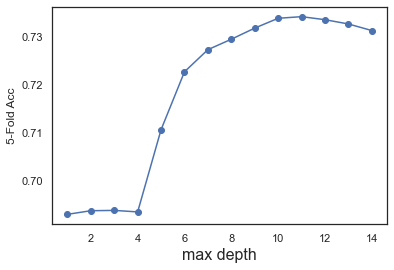

In [95]:
maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train_sp, y_train_sp)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

In [96]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(X_train_sp, y_train_sp)

y_pred = treeModel.predict(X_test_sp)
y_pred2 = treeModel.predict(X_test_p)

print("Accuracy de entrenamiento para datos balanceados",treeModel.score(X_train_sp, y_train_sp))
print("Accuracy de test para datos balanceados: ",treeModel.score(X_test_sp,y_test_sp))
print("Accuracy de test para datos originales: ",treeModel.score(X_test_p,y_test_p))
DTAcc = accuracy_score(y_pred2,y_test_p)

Accuracy de entrenamiento para datos balanceados 0.7515165812887571
Accuracy de test para datos balanceados:  0.735193673047542
Accuracy de test para datos originales:  0.6521008728177697


La **exactitud** es del **65.21%** para los datos originales y del **73.52%** para el caso de los datos balanceados. 

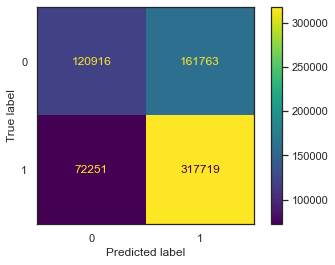

Accuracy :  0.6521008728177697
Sensitivity :  0.42775020429533145
Specificity :  0.8147267738543991
Positive Predictive Value :  0.6626296711868225


In [97]:
conf_matrix (y_test_p, y_pred2) 
metricas(y_test_p, y_pred2)

La matriz indica que hay 120916 datos reales eran 0 y el modelo los predijo correctamente, 317719 unos predichos de forma adecuada, 161763 falsos positivos y 72251 falsos negativos.

 Referente a los valores de las métricas obtenidas: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **42.77%**, un resultado un poco bajo. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **81.47%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **66.26%**, por lo que nuestro modelo escogido detecta correctamente en un moderado número de casos.

- **Random Forest**

best mean cross-validation score: 0.738
best parameters: {'max_depth': 13}


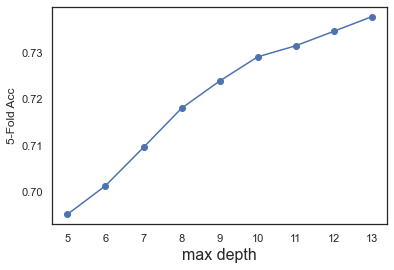

In [98]:
maxDepth = range(5,14)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(n_estimators = 20), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train_sp, y_train_sp)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

In [99]:
maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestClassifier(n_estimators = 20, max_depth=maxDepthOptimo).fit(X_train_sp, y_train_sp)

y_pred = rf.predict(X_test_sp)
y_pred2 = rf.predict(X_test_p)

print("Accuracy de entrenamiento para datos balanceados",rf.score(X_train_sp, y_train_sp))
print("Accuracy de test para datos balanceados: ",rf.score(X_test_sp,y_test_sp))
print("Accuracy de test para datos originales: ",rf.score(X_test_p,y_test_p))

RFAcc = accuracy_score(y_pred2,y_test_p)

Accuracy de entrenamiento para datos balanceados 0.7529769929001527
Accuracy de test para datos balanceados:  0.7364968095623259
Accuracy de test para datos originales:  0.6426055788382946


La **exactitud** es del **64.26%** para los datos originales y del **73.65%** para el caso de los datos balanceados. 

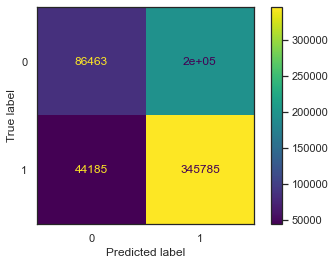

Accuracy :  0.6426055788382946
Sensitivity :  0.30586990897802807
Specificity :  0.8866964125445547
Positive Predictive Value :  0.6379785277148935


In [100]:
conf_matrix (y_test_p, y_pred2) 
metricas(y_test_p, y_pred2)

La matriz indica que hay 86463 datos reales eran 0 y el modelo los predijo correctamente, 345785 unos predichos de forma adecuada, 2e$^5$ falsos positivos y 44185 falsos negativos.

 Referente a los valores de las métricas obtenidas: 
- La **sensibilidad** representa la tasa de verdaderos positivos, es decir, la proporción entre los casos positivos bien clasificados por el modelo respecto al total de positivos. Tiene un valor del **30.59%**, un resultado un poco bajo. 

- La **especifidad** representa la tasa de verdaderos negativos, es la proporción entre los casos negativos bien clasificados por el modelo respecto al total de negativos. Tiene un valor de **88.67%**, lo que significa que su capacidad de discriminar los casos negativos es medianamente buena, por lo que es difícil obtener falsos negativos.

- El **valor predictivo positivo** la cual es la predicción, que en nuestro caso es del **63.80%**, por lo que nuestro modelo escogido detecta correctamente en un moderado número de casos.

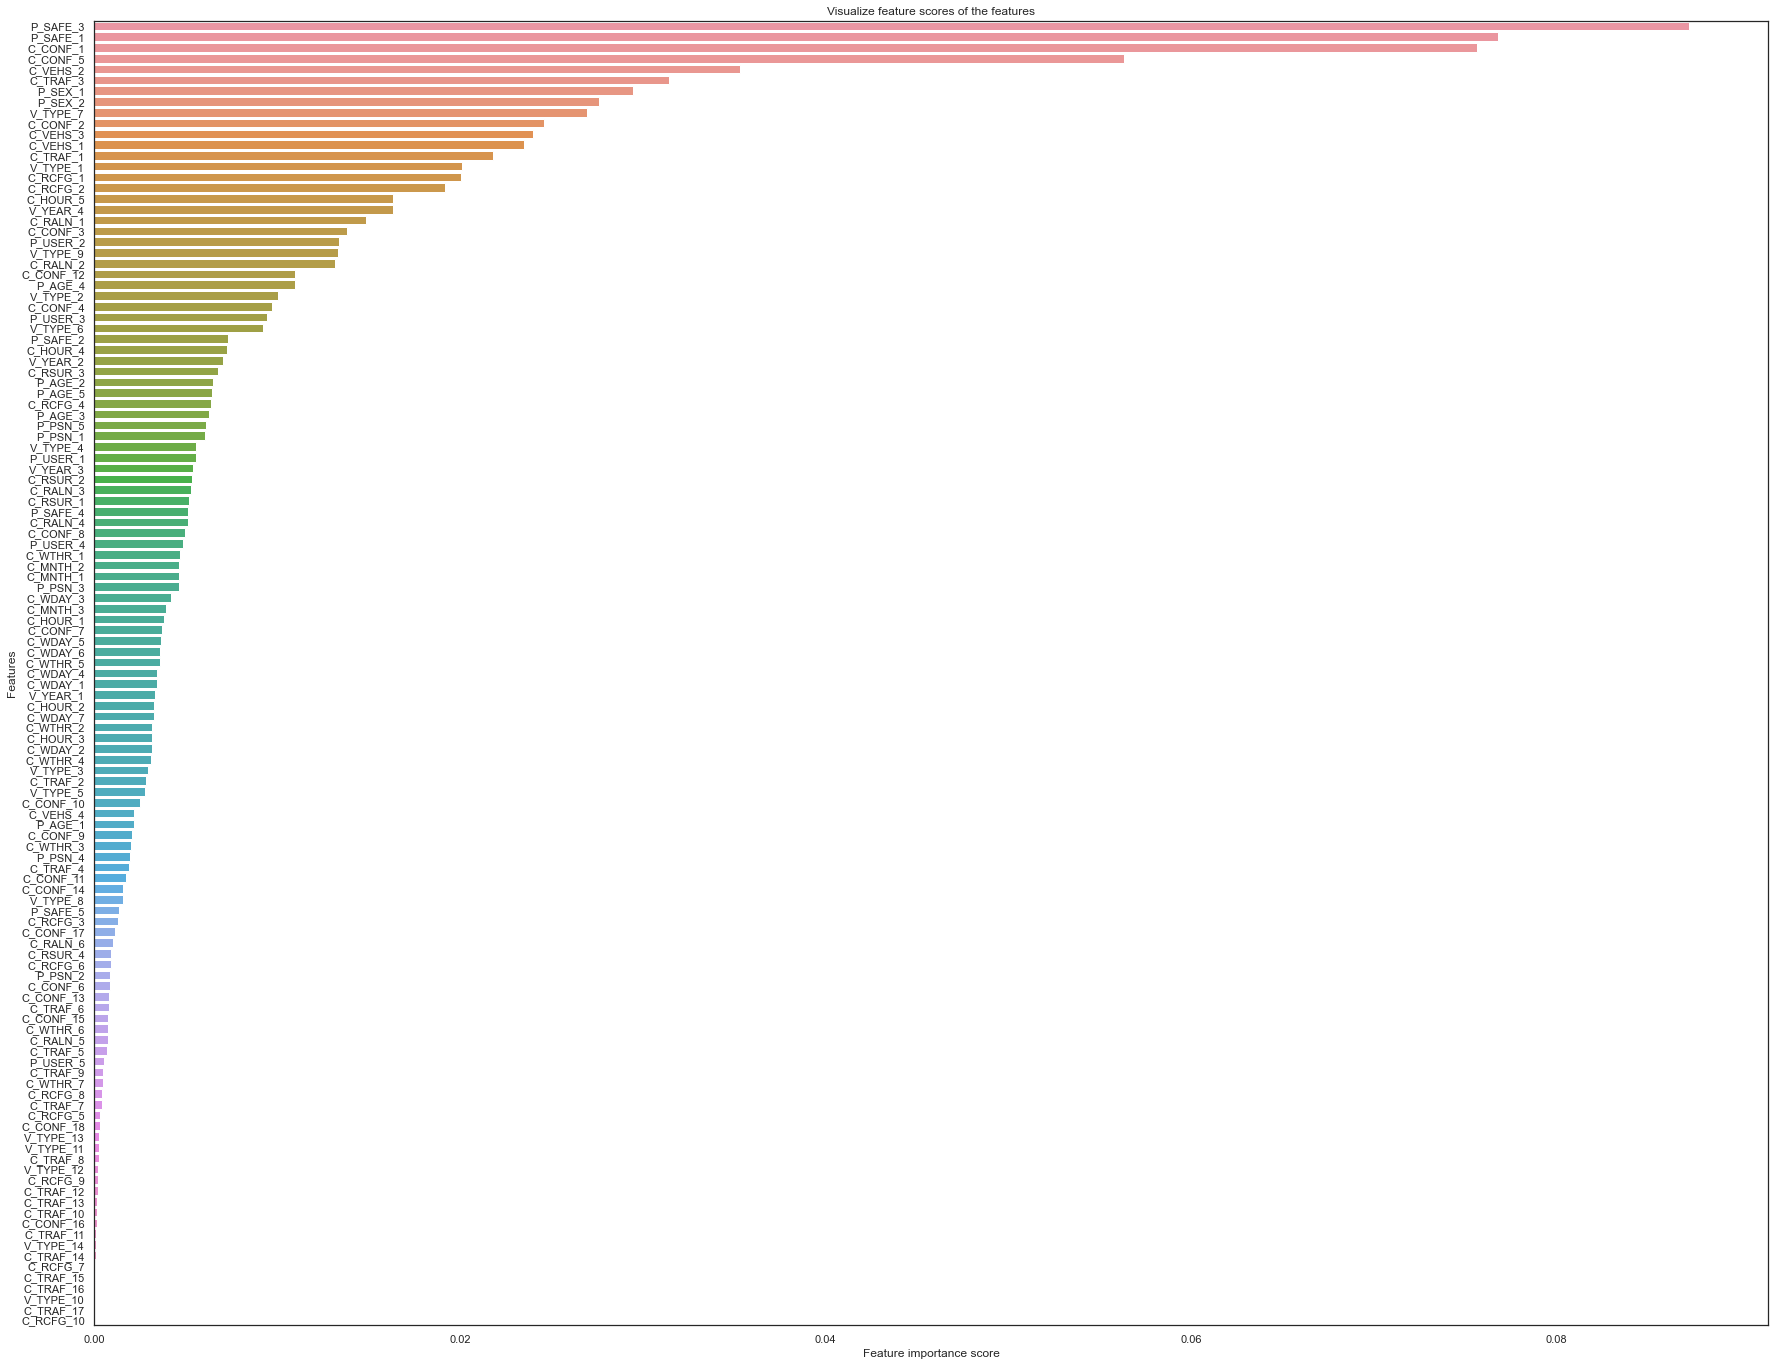

In [101]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train_p.columns).sort_values(ascending=False)

feature_scores
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [102]:
df['P_SAFE'].dtypes

CategoricalDtype(categories=[1, 2, 9, 10, 12, 13], ordered=False)

Según la gráfica, la variable con más importancia a la hora de clasificar si una colisión produce o no necesidad de tratamiento es `P_SAFE_1`. Correspondiente al método de seguridad utilizado.

- **Gradient Boost**

In [103]:
gbc = GradientBoostingClassifier(
              learning_rate=0.1,  max_depth=12,
              min_weight_fraction_leaf=0.02, n_estimators=130,
              random_state=2408,
              verbose=1)

gbc.fit(X_train_sp, y_train_sp)

      Iter       Train Loss   Remaining Time 
         1           1.2027            1.20m
         2           1.1774            1.26m
         3           1.1553            1.30m
         4           1.1364            1.32m
         5           1.1209            1.31m
         6           1.1072            1.32m
         7           1.0962            1.29m
         8           1.0863            1.29m
         9           1.0778            1.27m
        10           1.0706            1.26m
        20           1.0270            1.15m
        30           1.0079            1.05m
        40           0.9977           56.76s
        50           0.9920           50.83s
        60           0.9880           44.94s
        70           0.9845           38.60s
        80           0.9819           32.23s
        90           0.9795           25.42s
       100           0.9777           19.01s


GradientBoostingClassifier(max_depth=12, min_weight_fraction_leaf=0.02,
                           n_estimators=130, random_state=2408, verbose=1)

In [104]:
y_pred = gbc.predict(X_test_sp)
y_pred2 = gbc.predict(X_test_p)

print("Accuracy de entrenamiento para datos balanceados",gbc.score(X_train_sp, y_train_sp))
print("Accuracy de test para datos balanceados: ",gbc.score(X_test_sp,y_test_sp))
print("Accuracy de test para datos originales: ",gbc.score(X_test_p,y_test_p))

GBAcc = accuracy_score(y_pred2, y_test_p)

Accuracy de entrenamiento para datos balanceados 0.7500898714837781
Accuracy de test para datos balanceados:  0.7441808214253617
Accuracy de test para datos originales:  0.6580787305117528


La **exactitud** es del **65.80%** para los datos originales y del **74.42%** para el caso de los datos balanceados.

- **Comparación de los modelos**

In [105]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree','Random Forest','Gradient Boosting'], 
                        'Accuracy': [LRAcc*100, DTAcc*100,RFAcc*100,GBAcc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,Gradient Boosting,65.807873
1,Decision Tree,65.210087
2,Random Forest,64.260558
0,Logistic Regression,63.819615


Comparando los modelos por el valor **accuracy** (exactitud), obtenemos que el algoritmo con mayor precisión es **Gradient Boosting** con un **65.80%** en precisión. 

### 5. ACCIDENTES SEGÚN LOS DÍAS (FESTIVOS,VACACIONES,...)

In [106]:
df['C_WDAY'].value_counts()

5    573848
6    504468
4    494879
3    468540
2    466825
1    443184
7    411498
Name: C_WDAY, dtype: int64

Para realizar mejor el análisis vamos a dividir los días en no festivos (lunes, martes, miércoles, jueves, viernes) y festivos (sábados y domingos).

Para ello, transformamos la variable 'C_WDAY' en una variable dicotómica:
- **0**: días no festivos  
- **1**: días festivos

In [107]:
df['d_festivo']=np.where(df['C_WDAY']==6,1,np.where(df['C_WDAY']==7,1,0))
df['d_festivo'].value_counts()

0    2447276
1     915966
Name: d_festivo, dtype: int64

Text(0, 0.5, 'Frecuencias')

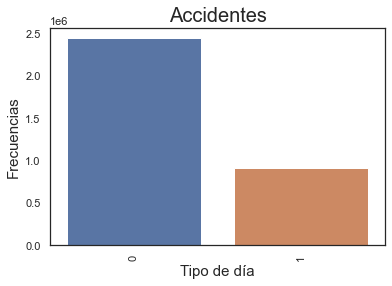

In [108]:
g= sns.countplot(df['d_festivo'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Accidentes", fontsize=20)
g.set_xlabel("Tipo de día", fontsize=15)
g.set_ylabel("Frecuencias", fontsize=15)

Se observa que hay una mayor cantidad de accidentes registrados en dias no festivos, aunque también hay que tener en cuenta que hay una descompensación entre días festivos (2 a la semana) y días no festivos (5 a la semana).

In [109]:
crosstab_sev_wday = pd.crosstab(index=df['C_SEV'], columns=df['d_festivo'], margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)
crosstab_sev_wday.index = ['Victima mortal', 'Sin victimas', 'Total']
crosstab_sev_wday.columns = ['Días no festivos', 'Días festivos','Total']
crosstab_sev_wday

,Días no festivos,Días festivos,Total
Victima mortal,1.086006,0.568202,1.654207
Sin victimas,71.679380,26.666413,98.345793
Total,72.765385,27.234615,100.000000


Hay un mayor número de accidentes en los días no festivos, tanto de los accidentes con víctimas mortales como de los sin víctimas.

In [110]:
medias= [df['C_SEV'].value_counts()[i]/df['d_festivo'].value_counts() for i in range(2)]
medias

[0    1.351546
 1    3.611059
 Name: d_festivo, dtype: float64,
 0    0.022733
 1    0.060739
 Name: d_festivo, dtype: float64]

Analizando todos los datos obtenidos, se observa que se producen más accidentes durante los días no festivos respecto a los días festivos.

### 6. CONCLUSIONES OBTENIDAS

Del estudio que se ha realizado se destaca que en cuanto a las variables objetivo, un **98.34%** de los accidentes no tienen víctimas mortales. Además, si la relacionamos con los días, se produce un mayor número de accidentes los días no festivos.

Haciendo referencia al estado de salud del accidentado, se tienen los valores: 1, si no hay lesiones; 2, si se ha lesionado; y 3, si ha fallecido. En este caso, hay un **57.29%** que tiene lesiones y un **42.02%**. Para el estudiio posterior y el modelado del problema, se tomaron los lesionados y fallecidos como aquellos que requirieron atención médica y los sanos como los que no la necesitaron.

Por otra parte, se sacó información sobre otras variables, que no fueran las objetivo. Por ejemplo, se vio que a lo largo del día, se puede hacer una agrupación por 5 franjas horarias, siendo la cuarta (15:00h - 19:59h) cuando más accidentes hay, **37.60%**. 

A parte, si nos referimos a los meses, en **Mayo, Junio, Julio y Agosto** es cuando más accidentes se producen. Si se tiene en cuenta el factor edad, al igual que en el caso de las horas, esta variable se ha dividido en 5 rangos, siendo el tercer rango (adultos de 30 años a 59 años) el que tiene un mayor número de accidentes.

También, notamos que a partir de 2 vehículos implicados, la proporción de fatalidades aumenta considerablemente. 


Otros aspectos a destacar son que, según la proporción de accidentes en función del año del vehículo, los modelos de coche que más accidentes tienen son los años de 1990 - 2000 y los que menos, los de los años 1970 - 1989. Además, incluso en condiciones de pavimento seco y en buenas condiciones hay muchos accidentes.

Se observa también que las condiciones del tiempo meteorológico y del pavimiento tienen gran correlación con las variables objetivo.

En cuanto a los modelos de clasificación llevados a cabo, se hicieron para las dos variables objetivo, regresión logística, árbol de decisión, random forest y gradient boost.

En el caso de los fallecidos, el Árbol de decisin  el mejor modelo en cuanto a precisión, con un **78%** en esta métrica. Se ha podido llegado a la conclusión de que la mayoría de los accidentes con fallecimiento son producidos por el propio vehículo, si se choca con un elemento estacionario.

Analizando los heridos o no heridos, se tiene exactitud del **65.80%**. El modelo con mayor precisión es tambien el de Gradient Boosting. Se ve además que la variable más importante en esta clasificación es la del dispositivo de seguridad utilizado.

Con la ayuda de un conjunto de datos sobre los días festivos o periodos de vacaciones en Canadá, se podría llegar mejor a una conclusión de si en los días festivos se producen más accidentes.